In [ ]:
!pip install python-dotenv boto3


In [ ]:
import os
import ast
import re
import json
import sys
from typing import List, Dict, Set, Optional, Any, Tuple
from pathlib import Path
import boto3
from botocore.exceptions import NoCredentialsError, ClientError
from urllib.parse import urlparse
from pydantic import BaseModel, Field, validator
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from dotenv import load_dotenv
import time


# S3 credentials

In [ ]:
from typing import List, Dict, Optional
import datetime
from urllib.parse import urlparse
from pydantic import BaseModel, Field, field_validator

In [ ]:


class S3Credentials(BaseModel):
    """Model for S3 bucket credentials."""
    bucket_uri: str
    aws_access_key_id: Optional[str] = None
    aws_secret_access_key: Optional[str] = None
    aws_session_token: Optional[str] = None
    region_name: Optional[str] = None

    @field_validator('bucket_uri')
    @classmethod
    def validate_bucket_uri(cls, v):
        parsed = urlparse(v)
        if parsed.scheme != 's3':
            raise ValueError("Bucket URI must use 's3' scheme")
        if not parsed.netloc:
            raise ValueError("Bucket URI must include bucket name")
        return v

    def get_bucket_name(self) -> str:
        """Extract bucket name from URI."""
        parsed = urlparse(self.bucket_uri)
        return parsed.netloc

    def get_prefix(self) -> str:
        """Extract prefix from URI."""
        parsed = urlparse(self.bucket_uri)
        # Remove leading slash if present
        return parsed.path.lstrip('/')

class CodeFile(BaseModel):
    """Represents a code file in the codebase."""
    filename: str
    content: str
    language: str = "unknown"
    modules: List[str] = []
    module_summaries: Dict[str, str] = {}
    functions: List[Dict[str, Any]] = []
    function_summaries: Dict[str, str] = {}


class AugmentedCodebase(BaseModel):
    """Represents the entire codebase with augmentations."""
    files: List[CodeFile]
    augmentation_timestamp: datetime.datetime = Field(default_factory=lambda: datetime.datetime.now())
    metadata: Dict[str, str] = {}

# S3 Handler

In [ ]:
class S3Handler:
    """Handles interactions with Amazon S3."""

    def __init__(self, credentials: S3Credentials):
        self.credentials = credentials
        self.s3_client = self._initialize_s3_client()
        self.bucket_name = credentials.get_bucket_name()
        self.prefix = credentials.get_prefix()

    def _initialize_s3_client(self):
        """Initialize the S3 client with provided credentials."""
        session_kwargs = {}

        if self.credentials.aws_access_key_id and self.credentials.aws_secret_access_key:
            session_kwargs['aws_access_key_id'] = self.credentials.aws_access_key_id
            session_kwargs['aws_secret_access_key'] = self.credentials.aws_secret_access_key

        if self.credentials.aws_session_token:
            session_kwargs['aws_session_token'] = self.credentials.aws_session_token

        if self.credentials.region_name:
            session_kwargs['region_name'] = self.credentials.region_name

        # If no credentials provided, boto3 will look for credentials in the environment
        session = boto3.Session(**session_kwargs)
        return session.client('s3')

    def upload_file(self, file_content: str, object_key: str) -> bool:
        """Upload a file to S3 bucket."""
        full_key = f"{self.prefix}/{object_key}" if self.prefix else object_key

        try:
            self.s3_client.put_object(
                Bucket=self.bucket_name,
                Key=full_key,
                Body=file_content
            )
            return True
        except (NoCredentialsError, ClientError) as e:
            print(f"Error uploading file to S3: {e}")
            return False

    def upload_json(self, data: dict, object_key: str) -> bool:
        """Upload JSON data to S3 bucket."""
        json_content = json.dumps(data)
        return self.upload_file(json_content, object_key)

    def list_objects(self, prefix: str = None) -> List[str]:
        """List objects in the bucket with optional prefix."""
        list_prefix = f"{self.prefix}/{prefix}" if self.prefix and prefix else (self.prefix or prefix or "")

        try:
            response = self.s3_client.list_objects_v2(
                Bucket=self.bucket_name,
                Prefix=list_prefix
            )

            if 'Contents' in response:
                return [obj['Key'] for obj in response['Contents']]
            return []
        except (NoCredentialsError, ClientError) as e:
            print(f"Error listing objects in S3: {e}")
            return []

    def file_exists(self, object_key: str) -> bool:
        """Check if a file exists in the S3 bucket."""
        full_key = f"{self.prefix}/{object_key}" if self.prefix else object_key

        try:
            self.s3_client.head_object(
                Bucket=self.bucket_name,
                Key=full_key
            )
            return True
        except (NoCredentialsError, ClientError) as e:
            # If the file doesn't exist, head_object returns an error
            return False

    def get_file_content(self, object_key: str) -> Optional[str]:
        """Get file content from S3 bucket."""
        full_key = f"{self.prefix}/{object_key}" if self.prefix else object_key

        try:
            response = self.s3_client.get_object(
                Bucket=self.bucket_name,
                Key=full_key
            )
            return response['Body'].read().decode('utf-8')
        except (NoCredentialsError, ClientError) as e:
            return None

# Define CodeParser Class

In [ ]:
from typing import Set, Tuple
import os
import ast
import re

class CodeParser:
    """Parses code files to extract modules and other information."""

    # Map file extensions to language names
    LANGUAGE_MAP = {
        '.py': 'python',
        '.pyw': 'python',
        '.js': 'javascript',
        '.jsx': 'javascript',
        '.ts': 'typescript',
        '.tsx': 'typescript',
        '.java': 'java',
        '.c': 'c',
        '.cc': 'cpp',
        '.cpp': 'cpp',
        '.cxx': 'cpp',
        '.c++': 'cpp',
        '.h': 'c/cpp',
        '.hpp': 'cpp',
        '.hxx': 'cpp',
        '.hh': 'cpp',
        '.sh': 'shell',
        '.bash': 'shell',
        '.zsh': 'shell',
        '.cs': 'csharp',
        '.go': 'go',
        '.rb': 'ruby',
        '.php': 'php',
        '.swift': 'swift',
        '.kt': 'kotlin',
        '.rs': 'rust',
    }

    @staticmethod
    def detect_language(filename: str) -> str:
        """Detect the programming language based on file extension."""
        _, ext = os.path.splitext(filename.lower())
        return CodeParser.LANGUAGE_MAP.get(ext, "unknown")

    @staticmethod
    def extract_modules_from_python(content: str) -> Set[str]:
        """Extract module names from Python code using AST."""
        modules = set()

        try:
            tree = ast.parse(content)

            # Process only top-level import statements
            for node in tree.body:
                if isinstance(node, ast.Import):
                    for name in node.names:
                        # Only take the first part of the module name
                        modules.add(name.name.split('.')[0])
                elif isinstance(node, ast.ImportFrom):
                    if node.module:
                        # Only take the first part of the module name
                        modules.add(node.module.split('.')[0])
        except SyntaxError:
            # Fallback to regex for code that can't be parsed
            import_pattern = r'import\s+([a-zA-Z0-9_\.]+)'
            from_pattern = r'from\s+([a-zA-Z0-9_\.]+)'

            for match in re.finditer(import_pattern, content):
                # Only take the first part of the module name
                modules.add(match.group(1).split('.')[0])

            for match in re.finditer(from_pattern, content):
                # Only take the first part of the module name
                modules.add(match.group(1).split('.')[0])

        return modules

    @staticmethod
    def extract_modules_from_js(content: str) -> Set[str]:
        """Extract module names from JavaScript/TypeScript code."""
        modules = set()

        # Look for require statements
        require_pattern = r'require\([\'"]([a-zA-Z0-9\-_]+)[\'"]'
        for match in re.finditer(require_pattern, content):
            modules.add(match.group(1))

        # Look for import statements
        import_pattern = r'import\s+(?:.+\s+from\s+)?[\'"]([a-zA-Z0-9\-_@/]+)[\'"]'
        for match in re.finditer(import_pattern, content):
            module_name = match.group(1)
            # Extract the package name (e.g., 'react' from '@react/core')
            if module_name.startswith('@'):
                parts = module_name.split('/')
                if len(parts) > 1:
                    module_name = parts[0][1:] + '/' + parts[1]
            else:
                module_name = module_name.split('/')[0]

            modules.add(module_name)

        return modules

    @staticmethod
    def extract_modules_from_c_cpp(content: str) -> Set[str]:
        """Extract module names from C/C++ code."""
        modules = set()

        # System includes with angle brackets: #include <stdio.h>
        system_include_pattern = r'#include\s*<([a-zA-Z0-9_./]+)>'
        for match in re.finditer(system_include_pattern, content):
            include_path = match.group(1)
            # Extract the base name without extension
            module_name = os.path.splitext(os.path.basename(include_path))[0]
            modules.add(module_name)

        # Local includes with quotes: #include "myheader.h"
        local_include_pattern = r'#include\s*"([a-zA-Z0-9_./]+)"'
        for match in re.finditer(local_include_pattern, content):
            include_path = match.group(1)
            # Extract the base name without extension
            module_name = os.path.splitext(os.path.basename(include_path))[0]
            modules.add(module_name)

        return modules

    @staticmethod
    def extract_modules_from_shell(content: str) -> Set[str]:
        """Extract module names from shell scripts."""
        modules = set()

        # Look for source commands: source file.sh or . file.sh
        source_pattern = r'(?:source|\.) \s*([a-zA-Z0-9_./\-]+)'
        for match in re.finditer(source_pattern, content):
            script_path = match.group(1)
            # Extract the base name without extension
            module_name = os.path.splitext(os.path.basename(script_path))[0]
            modules.add(module_name)

        # Look for common utilities and commands
        common_utils = [
            'awk', 'sed', 'grep', 'find', 'xargs', 'curl', 'wget',
            'tar', 'gzip', 'unzip', 'ssh', 'rsync', 'git', 'docker',
            'kubectl', 'jq', 'yq', 'awk', 'cut', 'tr', 'sort'
        ]

        for util in common_utils:
            if re.search(r'\b' + re.escape(util) + r'\b', content):
                modules.add(util)

        return modules

    @staticmethod
    def extract_modules_generic(content: str) -> Set[str]:
        """Generic module extraction for other languages."""
        modules = set()

        # Try to capture import/include/require patterns across various languages
        patterns = [
            r'import\s+([a-zA-Z0-9_.\-]+)',
            r'#include\s+[<"]([a-zA-Z0-9_.\-]+)[>"]',
            r'require\s+[\'"]([a-zA-Z0-9_.\-]+)[\'"]',
            r'using\s+([a-zA-Z0-9_.]+);'
        ]

        for pattern in patterns:
            for match in re.finditer(pattern, content):
                module_name = match.group(1).split('.')[0].split('/')[0]
                if module_name:
                    modules.add(module_name)

        return modules

    @staticmethod
    def extract_modules_from_file(filename: str, content: str) -> Tuple[Set[str], str]:
        """Extract modules based on file extension."""
        language = CodeParser.detect_language(filename)

        if language == 'python':
            modules = CodeParser.extract_modules_from_python(content)
        elif language in ['javascript', 'typescript']:
            modules = CodeParser.extract_modules_from_js(content)
        elif language in ['c', 'cpp', 'c/cpp']:
            modules = CodeParser.extract_modules_from_c_cpp(content)
        elif language == 'shell':
            modules = CodeParser.extract_modules_from_shell(content)
        else:
            modules = CodeParser.extract_modules_generic(content)

        return modules, language

In [ ]:
# Add this new class after the CodeParser class

class FunctionParser:
    """Parses code files to extract function definitions."""

    @staticmethod
    def extract_function_with_full_context(filename: str, content: str, function_name: str,
                                          class_name: str = None, is_method: bool = False) -> Dict[str, Any]:
        """Extract a function with its full context including docstrings, parameters, and surrounding code."""
        lines = content.split('\n')
        function_pattern = r'def\s+' + re.escape(function_name) + r'\s*\('

        # Find the function definition line
        func_start_idx = -1
        func_end_idx = -1
        in_function = False
        indent_level = 0

        for i, line in enumerate(lines):
            # Check for function definition
            if re.search(function_pattern, line) and not in_function:
                # If this is a method, check if it's within the specified class
                if is_method and class_name:
                    # Skip if we can't verify this is within the right class
                    if not any(re.search(r'class\s+' + re.escape(class_name) + r'\s*[:\(]', lines[j])
                              for j in range(max(0, i-100), i)):
                        continue

                func_start_idx = i
                in_function = True
                # Determine indent level from first non-empty line after definition
                for j in range(i+1, min(len(lines), i+20)):
                    if lines[j].strip() and not lines[j].strip().startswith('#'):
                        indent_level = len(lines[j]) - len(lines[j].lstrip())
                        break
                continue

            # Find the end of the function based on indentation
            if in_function:
                # Skip empty lines and comments
                if not line.strip() or line.strip().startswith('#'):
                    continue

                # Check if this line has less indentation than the function body
                if len(line) - len(line.lstrip()) <= indent_level and line.strip():
                    func_end_idx = i - 1
                    break

        # If we couldn't find the end, assume it's the end of the file
        if in_function and func_end_idx == -1:
            func_end_idx = len(lines) - 1

        if func_start_idx == -1:
            return {"function_text": "", "docstring": "", "parameters": []}

        # Extract the full function text
        function_text = '\n'.join(lines[func_start_idx:func_end_idx+1])

        # Extract docstring if present
        docstring = ""
        docstring_start = -1
        docstring_end = -1

        # Look for triple-quoted strings
        for i in range(func_start_idx + 1, min(func_end_idx, func_start_idx + 20)):
            line = lines[i].strip()
            if line.startswith('"""') or line.startswith("'''"):
                docstring_start = i
                quote_type = '"""' if line.startswith('"""') else "'''"

                # If the docstring is a one-liner
                if line.endswith(quote_type) and len(line) > 3:
                    docstring_end = i
                    docstring = line[3:-3]
                    break

                # Look for the closing quote
                for j in range(i + 1, func_end_idx + 1):
                    if quote_type in lines[j]:
                        docstring_end = j
                        docstring = '\n'.join([lines[docstring_start][3:]] +
                                             lines[docstring_start+1:docstring_end] +
                                             [lines[docstring_end].split(quote_type)[0]])
                        break

                if docstring_end != -1:
                    break

        # Look for parameters in the function definition
        param_line = lines[func_start_idx]
        param_match = re.search(r'\((.+?)\)', param_line)
        parameters = []

        if param_match:
            param_str = param_match.group(1)
            # Split by commas, but respect nested parentheses
            params = []
            current_param = ""
            paren_level = 0

            for char in param_str:
                if char == '(' or char == '[' or char == '{':
                    paren_level += 1
                    current_param += char
                elif char == ')' or char == ']' or char == '}':
                    paren_level -= 1
                    current_param += char
                elif char == ',' and paren_level == 0:
                    params.append(current_param.strip())
                    current_param = ""
                else:
                    current_param += char

            if current_param:
                params.append(current_param.strip())

            for param in params:
                if '=' in param:
                    name, default = param.split('=', 1)
                    parameters.append({"name": name.strip(), "default": default.strip()})
                else:
                    parameters.append({"name": param.strip(), "default": None})

        # Look for any function calls or references to this function in the file
        references = []
        ref_pattern = r'(?<![a-zA-Z0-9_])' + re.escape(function_name) + r'\s*\('

        for i, line in enumerate(lines):
            if i >= func_start_idx and i <= func_end_idx:
                continue  # Skip the function definition itself

            if re.search(ref_pattern, line):
                start_idx = max(0, i-1)
                end_idx = min(len(lines), i+2)
                references.append('\n'.join(lines[start_idx:end_idx]))

        # Get a wider context - look for related functions and imports
        context_start = max(0, func_start_idx - 100)
        context_before = '\n'.join(lines[context_start:func_start_idx])

        # Get imports that might be relevant
        imports = []
        for line in lines[:func_start_idx]:
            if re.match(r'\s*import\s+|from\s+.*import', line):
                imports.append(line.strip())

        return {
            "function_text": function_text,
            "docstring": docstring,
            "parameters": parameters,
            "context_before": context_before,
            "references": references,
            "imports": imports,
            "file": filename
        }


    @staticmethod
    def extract_functions_from_python(content: str) -> List[Dict[str, Any]]:
        """Extract function definitions from Python code using AST."""
        functions = []

        try:
            tree = ast.parse(content)

            # Track class context for methods
            class_stack = []

            for node in ast.walk(tree):
                if isinstance(node, ast.ClassDef):
                    class_stack.append(node.name)

                    # Process methods directly to maintain class context
                    for item in node.body:
                        if isinstance(item, ast.FunctionDef):
                            method_name = item.name
                            docstring = ast.get_docstring(item)

                            method_info = {
                                'name': method_name,
                                'docstring': docstring or "",
                                'class_name': node.name,
                                'is_method': True
                            }

                            functions.append(method_info)

                elif isinstance(node, ast.FunctionDef) and not hasattr(node, '_processed'):
                    # Skip methods (processed directly in ClassDef)
                    if class_stack:
                        node._processed = True
                        continue

                    # Extract function name
                    func_name = node.name

                    # Extract docstring if available
                    docstring = ast.get_docstring(node)

                    # Extract basic info
                    function_info = {
                        'name': func_name,
                        'docstring': docstring or "",
                        'class_name': None,
                        'is_method': False
                    }

                    # Add to list
                    functions.append(function_info)
                    node._processed = True

        except SyntaxError:
            # Fallback to regex for code that can't be parsed
            function_pattern = r'def\s+([a-zA-Z0-9_]+)\s*\('
            class_pattern = r'class\s+([a-zA-Z0-9_]+)'

            # Extract classes
            classes = []
            class_matches = list(re.finditer(class_pattern, content))
            for i, class_match in enumerate(class_matches):
                class_name = class_match.group(1)
                start_pos = class_match.end()
                end_pos = len(content)
                if i < len(class_matches) - 1:
                    end_pos = class_matches[i + 1].start()

                class_code = content[start_pos:end_pos]
                classes.append((class_name, class_code, start_pos))

            # Extract standalone functions
            for func_match in re.finditer(function_pattern, content):
                func_name = func_match.group(1)
                position = func_match.start()

                # Check if this function is a method of a class
                is_method = False
                class_name = None
                for name, code, start_pos in classes:
                    if start_pos <= position and position <= start_pos + len(code):
                        is_method = True
                        class_name = name
                        break

                function_info = {
                    'name': func_name,
                    'docstring': "",  # Can't reliably extract docstrings with regex
                    'class_name': class_name,
                    'is_method': is_method
                }

                functions.append(function_info)

        return functions

    @staticmethod
    def extract_functions_from_cpp(content: str) -> List[Dict[str, Any]]:
        """Extract function definitions from C/C++ code using regex."""
        functions = []

        # Regular expression to match function declarations
        # This is a simplified pattern and might not catch all C++ function variants
        function_pattern = r'(?:(?:virtual|static|inline|explicit)\s+)?(?:[a-zA-Z0-9_:]+(?:<[^>]*>)?)\s+([a-zA-Z0-9_]+)\s*\([^)]*\)\s*(?:const|override|final|noexcept)?\s*(?:{\s*)?'

        # Try to identify class context
        class_pattern = r'class\s+([a-zA-Z0-9_]+)'
        classes = []
        class_matches = list(re.finditer(class_pattern, content))
        for i, class_match in enumerate(class_matches):
            class_name = class_match.group(1)
            start_pos = class_match.end()
            end_pos = len(content)
            if i < len(class_matches) - 1:
                end_pos = class_matches[i + 1].start()

            class_code = content[start_pos:end_pos]
            classes.append((class_name, class_code, start_pos))

        for match in re.finditer(function_pattern, content):
            func_name = match.group(1)

            # Skip common false positives (if, for, while statements)
            if func_name in ['if', 'for', 'while', 'switch', 'return']:
                continue

            position = match.start()

            # Check if this function is a method of a class
            is_method = False
            class_name = None
            for name, code, start_pos in classes:
                if start_pos <= position and position <= start_pos + len(code):
                    is_method = True
                    class_name = name
                    break

            function_info = {
                'name': func_name,
                'docstring': "",  # C++ docstrings not captured here
                'class_name': class_name,
                'is_method': is_method
            }

            functions.append(function_info)

        return functions

    @staticmethod
    def extract_functions_generic(content: str) -> List[Dict[str, Any]]:
        """Generic function extraction for other languages."""
        functions = []

        # Try to capture common function/method patterns across languages
        patterns = [
            r'function\s+([a-zA-Z0-9_]+)\s*\(',  # JavaScript/TypeScript
            r'def\s+([a-zA-Z0-9_]+)\s*\(',      # Python, Ruby
            r'(?:public|private|protected|static|final)?\s+(?:[a-zA-Z0-9_<>]+\s+)+([a-zA-Z0-9_]+)\s*\(',  # Java/C#
        ]

        for pattern in patterns:
            for match in re.finditer(pattern, content):
                func_name = match.group(1)

                function_info = {
                    'name': func_name,
                    'docstring': "",
                    'class_name': None,
                    'is_method': False
                }

                functions.append(function_info)

        return functions

    @staticmethod
    def extract_functions_from_file(filename: str, content: str) -> Tuple[List[Dict[str, Any]], str]:
        """Extract functions based on file extension."""
        language = CodeParser.detect_language(filename)

        if language == 'python':
            functions = FunctionParser.extract_functions_from_python(content)
        elif language in ['javascript', 'typescript']:
            functions = FunctionParser.extract_functions_generic(content)  # Use generic for JS/TS
        elif language in ['c', 'cpp', 'c/cpp']:
            functions = FunctionParser.extract_functions_from_cpp(content)
        else:
            functions = FunctionParser.extract_functions_generic(content)

        return functions, language

# Add this new class after FunctionParser

# Find FunctionSummarizer class and replace its summarize_function method

class FunctionSummarizer:
    """Generates improved summaries for function definitions."""

    @staticmethod
    def summarize_function(function_info: Dict[str, Any], file_content: str = None) -> str:
        """Generate a summary for a function based on its name, docstring and context."""
        name = function_info.get('name', '')
        docstring = function_info.get('docstring', '')
        class_name = function_info.get('class_name')
        is_method = function_info.get('is_method', False)

        # If we have file content, extract detailed function context
        if file_content and name:
            enhanced_info = FunctionParser.extract_function_with_full_context(
                function_info.get('filename', 'unknown'),
                file_content,
                name,
                class_name,
                is_method
            )

            # Use the docstring if it's more detailed
            if enhanced_info['docstring'] and len(enhanced_info['docstring']) > len(docstring):
                docstring = enhanced_info['docstring']

            # Try to generate a more meaningful summary from the enhanced context
            if enhanced_info['function_text']:
                # Extract first sentence from docstring if available
                if docstring:
                    first_sentence = re.split(r'\.(?:\s|$)', docstring.strip())[0].strip()
                    if first_sentence:
                        return first_sentence

                # Try to generate a summary from parameters and function body
                param_names = [p['name'] for p in enhanced_info['parameters']
                              if p['name'] not in ('self', 'cls')]

                # Look for return statements
                returns_match = re.search(r'return\s+([^#\n]+)', enhanced_info['function_text'])
                returns_value = returns_match.group(1).strip() if returns_match else None

                # Create a descriptive summary
                if param_names and returns_value:
                    return f"Processes {', '.join(param_names)} and returns {returns_value}"
                elif param_names:
                    return f"Handles {', '.join(param_names)}"
                elif returns_value:
                    return f"Returns {returns_value}"

                # Check if it modifies or accesses object state (for methods)
                if is_method and class_name:
                    if re.search(r'self\.[a-zA-Z0-9_]+\s*=', enhanced_info['function_text']):
                        return f"Modifies {class_name} state based on {name.replace('_', ' ')}"
                    elif re.search(r'self\.[a-zA-Z0-9_]+', enhanced_info['function_text']):
                        return f"Accesses {class_name} state for {name.replace('_', ' ')}"

        # If there's a docstring, use its first line as a summary
        if docstring:
            first_line = docstring.split('\n')[0].strip()
            if first_line:
                return first_line

        # Try to extract parameters and return type from file content for better fallback
        params_str = ""
        return_type = ""

        if file_content:
            # Look for function definition
            func_pattern = r'(\w+)\s+' + re.escape(name) + r'\s*\(([^)]*)\)'
            func_match = re.search(func_pattern, file_content)

            if func_match:
                return_type_match = func_match.group(1)
                if return_type_match not in ['if', 'for', 'while', 'switch']:
                    return_type = f" returning {return_type_match}"

                # Extract parameters
                params = [p.strip() for p in func_match.group(2).split(',') if p.strip()]
                if params:
                    # Try to extract parameter names without types
                    param_names = []
                    for p in params:
                        parts = p.split()
                        if parts:
                            param_names.append(parts[-1].replace('*', ''))

                    if param_names:
                        params_str = f" processing {', '.join(param_names)}"

        # Common function name patterns
        if name.startswith('get_'):
            return f"Retrieves {name[4:].replace('_', ' ')}"
        if name.startswith('set_'):
            return f"Sets {name[4:].replace('_', ' ')}"
        if name.startswith('is_'):
            return f"Checks if {name[3:].replace('_', ' ')}"
        if name.startswith('has_'):
            return f"Checks if has {name[4:].replace('_', ' ')}"
        if name.startswith('create_'):
            return f"Creates {name[7:].replace('_', ' ')}"
        if name.startswith('update_'):
            return f"Updates {name[7:].replace('_', ' ')}"
        if name.startswith('delete_'):
            return f"Deletes {name[7:].replace('_', ' ')}"
        if name.startswith('validate_'):
            return f"Validates {name[9:].replace('_', ' ')}"
        if name.startswith('process_'):
            return f"Processes {name[8:].replace('_', ' ')}"
        if name.startswith('handle_'):
            return f"Handles {name[7:].replace('_', ' ')}"
        if name.startswith('parse_'):
            return f"Parses {name[6:].replace('_', ' ')}"
        if name.startswith('convert_'):
            return f"Converts {name[8:].replace('_', ' ')}"
        if name.startswith('extract_'):
            return f"Extracts {name[8:].replace('_', ' ')}"
        if name.startswith('calculate_'):
            return f"Calculates {name[10:].replace('_', ' ')}"
        if name.startswith('compute_'):
            return f"Computes {name[8:].replace('_', ' ')}"
        if name.startswith('find_'):
            return f"Finds {name[5:].replace('_', ' ')}"
        if name.startswith('search_'):
            return f"Searches for {name[7:].replace('_', ' ')}"
        if name.startswith('load_'):
            return f"Loads {name[5:].replace('_', ' ')}"
        if name.startswith('save_'):
            return f"Saves {name[5:].replace('_', ' ')}"
        if name.startswith('init_'):
            return f"Initializes {name[5:].replace('_', ' ')}"
        if name.startswith('setup_'):
            return f"Sets up {name[6:].replace('_', ' ')}"
        if name.startswith('test_'):
            return f"Tests {name[5:].replace('_', ' ')}"

        # For methods, include the class name in the summary
        if is_method and class_name:
            return f"Method for {name.replace('_', ' ')} in {class_name} class"

        # Enhanced fallback with any extracted parameter and return info
        return f"Handles {name.replace('_', ' ')}{params_str}{return_type}"

# Add this class which is referenced but not defined in the original code

class EnhancedModuleSummarizer:
    """Generates enhanced summaries for modules using Claude API."""

    def __init__(self, claude_api_handler=None, use_api=True):
        """Initialize the enhanced module summarizer."""
        self.base_summarizer = ModuleSummarizer()
        self.claude_api_handler = claude_api_handler
        self.use_api = use_api and claude_api_handler is not None and claude_api_handler.is_available()

    def summarize_module(self, module_name: str, language: str = "unknown", file_context: Optional[str] = None) -> str:
        """Generate a summary for a module, potentially enhanced by Claude API."""
        # Check if the module has a predefined description
        if module_name in self.base_summarizer.MODULE_DESCRIPTIONS:
            return self.base_summarizer.MODULE_DESCRIPTIONS[module_name]

        # Try to use Claude API for enhanced summaries
        if self.use_api and self.claude_api_handler:
            try:
                # Create request
                request = ModuleSummaryRequest(
                    module_name=module_name,
                    language=language,
                    file_context=file_context
                )

                # Get summary from Claude API
                response = self.claude_api_handler.generate_module_summary(request)

                # Return the enhanced summary
                return response.summary
            except Exception as e:
                # Fall back to basic summary if API fails
                print(f"Warning: Claude API call failed: {e}")

        # Fall back to basic summary
        return self.base_summarizer.summarize_module(module_name, language)

In [ ]:
# Replace the existing enhance_summaries_with_api function
# Add these helper functions before your main flow

def filter_false_functions(functions):
    """Remove common keywords and control structures misidentified as functions."""
    keywords = {'if', 'for', 'while', 'switch', 'return', 'else', 'size', 'type',
                'port', 'array', 'stream', 'read', 'printf', 'vector', 'case'}

    return [func for func in functions if
            func['name'] not in keywords and
            len(func['name']) > 2 and  # Skip very short names
            not func['name'].isdigit() and  # Skip numeric names
            not func['name'].startswith('_')]  # Skip internal helpers

def score_function_importance(func_name, file_content):
    """Score how important a function is for documentation."""
    score = 0

    # Functions with more parameters are likely more complex
    param_match = re.search(r'\b' + re.escape(func_name) + r'\s*\(([^)]*)\)', file_content)
    if param_match:
        params = param_match.group(1).split(',')
        score += len(params) * 5

    # Functions referenced more often are important
    score += file_content.count(func_name) * 2

    # Public API functions (no underscore prefix) are important
    if not func_name.startswith('_'):
        score += 10

    # Functions with certain prefixes are likely important APIs
    important_prefixes = ['create_', 'init_', 'get_', 'set_', 'handle_', 'process_',
                         'update_', 'add_', 'remove_', 'delete_', 'check_', 'parse_',
                         'read_', 'write_', 'convert_', 'calculate_', 'validate_']

    if any(func_name.startswith(prefix) for prefix in important_prefixes):
        score += 15

    # Functions with these words in them are likely important
    important_keywords = ['config', 'stream', 'init', 'connect', 'setup', 'main', 'handler']
    if any(keyword in func_name for keyword in important_keywords):
        score += 10

    return score
def enhance_summaries_with_api(augmented_data: Dict[str, Any], api_key_path: str = '/content/drive/MyDrive/tsn avb_data/claudkey.env') -> Dict[str, Any]:
    """
    Directly enhance module and function summaries using Claude API.
    This function processes the augmented data after the basic processing is complete.
    """
    print("Starting direct enhancement using Claude API...")

    # Load API key
    try:
        with open(api_key_path, 'r') as f:
            content = f.read().strip()

        if "API_KEY" in content:
            api_key = content.split("API_KEY =")[1].strip().strip('"\'')
            print(f"API key loaded successfully: {api_key[:5]}...{api_key[-5:]}")
        else:
            print("ERROR: API_KEY identifier not found in file")
            return augmented_data
    except Exception as e:
        print(f"Error loading API key: {e}")
        return augmented_data

    # Initialize Claude client
    client = anthropic.Anthropic(api_key=api_key)
    model = "claude-3-7-sonnet-20250219"
    print(f"Using Claude model: {model}")

    # Get data structures
    files = augmented_data["augmented_codebase"]["files"]
    module_summaries = augmented_data["module_summaries"]
    function_summaries = augmented_data["function_summaries"]
    all_file_contents = {}
    file_functions = {}

    # Extract file contents for context
    print("Extracting file contents for context...")
    for file_data in files:
        all_file_contents[file_data["filename"]] = (file_data["content"], file_data["language"])
        # Store functions by filename
        file_functions[file_data["filename"]] = {}
        for func in file_data.get("functions", []):
            if "name" in func:
                file_functions[file_data["filename"]][func["name"]] = func

    # Enhance module summaries
    print(f"\nEnhancing module summaries with Claude API...")
    api_call_count = 0
    success_count = 0

    # Process modules
    modules_to_process = list(module_summaries.keys())

    for module in modules_to_process:
        # Skip modules that already have good summaries
        if len(module_summaries[module]) > 50 and "module" not in module_summaries[module].lower():
            print(f"\nSkipping module {module}, already has good summary")
            continue

        print(f"\nProcessing module: {module}")

        # Find files that use this module
        context_files = []
        for filename, (content, language) in all_file_contents.items():
            if module in content.lower():  # Simple text search for module name
                context_files.append((filename, content))
                if len(context_files) >= 3:  # Now use 3 files for better context
                    break

        if not context_files:
            print(f"No context files found for module {module}, skipping...")
            continue

        # Build context from files
        context = ""
        for filename, content in context_files:
            # Extract a portion of the file around where the module is mentioned
            module_pos = content.lower().find(module.lower())
            if module_pos >= 0:
                start_pos = max(0, module_pos - 1000)
                end_pos = min(len(content), module_pos + 3000)
                excerpt = content[start_pos:end_pos]
                context += f"--- From file: {filename} ---\n{excerpt}\n\n"

        # Create prompt for Claude
        prompt = f"""
        Please provide a concise summary for the following module in a programming language:

        Module name: {module}

        I need you to analyze the provided code context to understand what this module does.
        Pay special attention to how the module is imported and used in the code examples.
        If it's a standard library module, explain its general purpose.
        If it's a custom module, infer its functionality from how it's used in the context.

        The summary should be brief (1-2 sentences) but informative, explaining what functionality
        this module/library provides. Focus on the main purpose and key features.

        Here's some context from files using this module:

        ```
        {context}
        ```

        Response format: Only provide the summary text, nothing else.
        """

        # Call Claude API
        try:
            print(f"Making API call for module: {module}")
            api_call_count += 1

            response = client.messages.create(
                model=model,
                max_tokens=150,
                temperature=0.2,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )

            # Extract and use the summary
            enhanced_summary = response.content[0].text.strip()
            print(f"API call successful. Summary: {enhanced_summary[:100]}...")

            # Update the summary in the augmented data
            module_summaries[module] = enhanced_summary
            success_count += 1

            # Small delay to avoid rate limiting
            time.sleep(0.2)

        except Exception as e:
            print(f"Error with API call for module {module}: {e}")

    # Process files with functions - increase to process more files
    print(f"\nEnhancing function summaries with Claude API...")

    # Process top files with most functions
    files_with_functions = [(filename, len(file_functions.get(filename, {})))
                            for filename in all_file_contents.keys()]
    files_with_functions.sort(key=lambda x: x[1], reverse=True)

    # Process top 10 files with most functions (increased from 3)
    top_files = [f for f, count in files_with_functions[:10] if count > 5]  # Only files with at least 5 functions

    for filename in top_files:
        print(f"\nProcessing functions from file: {filename}")
        content, language = all_file_contents.get(filename, ("", "unknown"))

        # Get functions in this file and filter out false positives
        all_funcs = list(file_functions.get(filename, {}).keys())
        file_funcs = filter_false_functions([{"name": func_name} for func_name in all_funcs])
        file_funcs = [f["name"] for f in file_funcs]

        # Score and sort functions by importance
        scored_functions = [(func_name, score_function_importance(func_name, content))
                           for func_name in file_funcs]
        scored_functions.sort(key=lambda x: x[1], reverse=True)

        # Process up to 20 most important functions per file
        for func_name, score in scored_functions[:20]:
            if func_name.startswith("_") or func_name in ["if", "for", "while"]:
                print(f"Skipping special/utility function: {func_name}")
                continue

            print(f"Processing function: {func_name}")

            # Several function patterns for different languages/conventions
            function_patterns = [
                # C-style
                r'(?:static\s+)?(?:inline\s+)?(?:int|void|char|struct|unsigned|float|double|long|\w+_t)\s+' + re.escape(func_name) + r'\s*\((?:[^)]*)\)(?:\s*{)?',
                # Function-style
                r'(?:function\s+)?' + re.escape(func_name) + r'\s*\((?:[^)]*)\)(?:\s*{)?',
                # Python-style
                r'def\s+' + re.escape(func_name) + r'\s*\((?:[^)]*)\)(?:\s*:)?',
                # General function pattern as fallback
                r'\b' + re.escape(func_name) + r'\s*\([^)]*\)'
            ]

            # Try each pattern
            func_pos = -1
            matched_pattern = None

            for pattern in function_patterns:
                match = re.search(pattern, content)
                if match:
                    func_pos = match.start()
                    matched_pattern = match.group(0)
                    break

            if func_pos == -1:
                print(f"Function {func_name} not found in {filename} using any pattern, skipping...")
                continue

            # Extract context around the function
            start_pos = max(0, func_pos - 500)
            end_pos = min(len(content), func_pos + 2000)
            func_context = content[start_pos:end_pos]

            # Look for related function calls to add to context
            related_calls = []
            for line_no, line in enumerate(content.split('\n')):
                if func_name in line and "(" in line:
                    line_pos = sum(len(l) + 1 for l in content.split('\n')[:line_no])
                    if abs(line_pos - func_pos) > 200:  # Only add calls that aren't part of the function definition
                        call_start = max(0, line_no - 2)
                        call_end = min(len(content.split('\n')), line_no + 3)
                        related_calls.append('\n'.join(content.split('\n')[call_start:call_end]))
                        if len(related_calls) >= 3:  # Limit to 3 related calls
                            break

            # Add related calls to context
            if related_calls:
                func_context += "\n\n/* Related function calls: */\n" + "\n---\n".join(related_calls)

            # Create prompt for Claude
            prompt = f"""
            Please provide a concise summary for the following function:

            Function name: {func_name}
            File: {filename}
            Function declaration: {matched_pattern}

            I need you to analyze the provided code context to understand what this function does.
            Look at the function signature, parameters, and implementation to determine its purpose.
            Pay special attention to any comments or documentation before the function.

            The summary should be brief (1 sentence) but informative, explaining what functionality
            this function provides. Include what it does and key parameters or return values.

            Here's the function code context:

            ```
            {func_context}
            ```

            Response format: Only provide the summary text, nothing else.
            """

            # Call Claude API
            try:
                print(f"Making API call for function: {func_name}")
                api_call_count += 1

                response = client.messages.create(
                    model=model,
                    max_tokens=150,
                    temperature=0.2,
                    messages=[
                        {"role": "user", "content": prompt}
                    ]
                )

                # Extract and use the summary
                enhanced_summary = response.content[0].text.strip()
                print(f"API call successful. Summary: {enhanced_summary[:100]}...")

                # Update the summary in the augmented data
                function_id = f"{filename}:{func_name}"
                function_summaries[function_id] = enhanced_summary
                success_count += 1

                # Update the function summaries in the file's data
                for file_data in files:
                    if file_data["filename"] == filename:
                        if "function_summaries" not in file_data:
                            file_data["function_summaries"] = {}
                        file_data["function_summaries"][func_name] = enhanced_summary

                # Small delay to avoid rate limiting
                time.sleep(0.2)

            except Exception as e:
                print(f"Error with API call for function {func_name}: {e}")

    print(f"\nAPI Enhancement completed: {success_count}/{api_call_count} successful API calls")

    # Update the augmented data
    augmented_data["module_summaries"] = module_summaries
    augmented_data["function_summaries"] = function_summaries

    return augmented_data

In [ ]:
def score_function_importance(func_name, file_content):
    """Score how important a function is for documentation."""
    score = 0

    # Functions with more parameters are likely more complex
    param_match = re.search(r'\b' + re.escape(func_name) + r'\s*\(([^)]*)\)', file_content)
    if param_match:
        params = param_match.group(1).split(',')
        score += len(params) * 5

    # Functions referenced more often are important
    score += file_content.count(func_name) * 2

    # Public API functions (no underscore prefix) are important
    if not func_name.startswith('_'):
        score += 10

    # Functions with certain prefixes are likely important APIs
    important_prefixes = ['create_', 'init_', 'get_', 'set_', 'handle_', 'process_',
                         'update_', 'add_', 'remove_', 'delete_', 'check_', 'parse_',
                         'read_', 'write_', 'convert_', 'calculate_', 'validate_']

    if any(func_name.startswith(prefix) for prefix in important_prefixes):
        score += 15

    # Functions with these words in them are likely important
    important_keywords = ['config', 'stream', 'init', 'connect', 'setup', 'main', 'handler']
    if any(keyword in func_name for keyword in important_keywords):
        score += 10

    return score

# Claud integration

In [ ]:
!pip install anthropic pydantic


In [ ]:
import os
from typing import List, Dict, Optional
from pydantic import BaseModel, Field
import anthropic

In [ ]:
# Pydantic models for Claude API
class ModuleSummaryRequest(BaseModel):
    """Request structure for module summary generation."""
    module_name: str
    language: str
    file_context: Optional[str] = None

class ModuleSummaryResponse(BaseModel):
    """Response structure for module summary generation."""
    module_name: str
    summary: str
    language: str
    detailed_description: Optional[str] = None

class ClaudeAPIHandler:
    """Handles interactions with Claude API for enhanced module summaries."""

    def __init__(self, api_key_path: str = None):
        """Initialize the Claude API client with the API key."""
        print("Initializing Claude API Handler...")
        self.api_key = self._load_api_key(api_key_path)

        if self.api_key:
            print(f"API key loaded successfully: {self.api_key[:5]}...{self.api_key[-5:]}")
            self.client = anthropic.Anthropic(api_key=self.api_key)
            self.model = "claude-3-7-sonnet-20250219"  # Claude 3.7 Sonnet model
            print(f"Using model: {self.model}")
        else:
            print("Failed to load API key")
            self.client = None
            self.model = None

    def _load_api_key(self, api_key_path: str = None) -> Optional[str]:
        """Load Claude API key from the specified file."""
        if not api_key_path:
            # Default path from user specification
            api_key_path = '/content/drive/MyDrive/tsn avb_data/claudkey.env'

        print(f"Looking for Claude API key at: {api_key_path}")

        if not os.path.exists(api_key_path):
            print(f"Warning: Claude API key file not found at {api_key_path}")
            return None

        try:
            with open(api_key_path, 'r') as f:
                content = f.read().strip()

            print(f"API key file content length: {len(content)} characters")

            # Extract the API key
            if "API_KEY" in content:
                # Parse "API_KEY = "value"" format
                api_key = content.split("API_KEY =")[1].strip().strip('"\'')
                return api_key
            else:
                print("Warning: API_KEY not found in the file")
                return None

        except Exception as e:
            print(f"Error loading Claude API key: {e}")
            return None

    def test_connection(self) -> bool:
        """Test the connection to Claude API."""
        if not self.is_available():
            print("Claude API is not available. Check API key.")
            return False

        try:
            print("Testing Claude API connection...")
            response = self.client.messages.create(
                model=self.model,
                max_tokens=10,
                temperature=0.0,
                messages=[
                    {"role": "user", "content": "Say hello"}
                ]
            )

            if response and response.content:
                print(f"Claude API test successful: {response.content[0].text}")
                return True
            else:
                print("Claude API test failed: No response content")
                return False

        except Exception as e:
            print(f"Claude API test failed with error: {e}")
            return False

    def is_available(self) -> bool:
        """Check if the Claude API is available for use."""
        return self.client is not None and self.api_key is not None

    def generate_module_summary(self, request: ModuleSummaryRequest) -> ModuleSummaryResponse:
        """Generate an enhanced module summary using Claude API."""
        if not self.is_available():
            raise ValueError("Claude API is not available. Check API key.")

        # Create the context section separately to avoid nested f-strings with backslashes
        context_section = ""
        if request.file_context:
            context_section = "Here's some context from files using this module:\n\n```\n" + request.file_context + "\n```"

        # Create the prompt for Claude
        prompt = f"""
        Please provide a concise summary for the following module in {request.language} programming language:

        Module name: {request.module_name}

        I need you to analyze the provided code context to understand what this module does.
        Pay special attention to how the module is imported and used in the code examples.
        If it's a standard library module, explain its general purpose.
        If it's a custom module, infer its functionality from how it's used in the context.

        The summary should be brief (1-2 sentences) but informative, explaining what functionality
        this module/library provides. Focus on the main purpose and key features.

        {context_section}

        Response format: Only provide the summary text, nothing else.
        """

        print(f"Sending request to Claude API for module: {request.module_name}")
        print(f"Context length: {len(request.file_context) if request.file_context else 0} characters")

        # Call Claude API
        try:
            response = self.client.messages.create(
                model=self.model,
                max_tokens=150,
                temperature=0.2,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )

            # Extract summary from response
            summary = response.content[0].text.strip()
            print(f"Claude API response for {request.module_name}: {summary[:100]}...")

            # Create and return the response model
            return ModuleSummaryResponse(
                module_name=request.module_name,
                summary=summary,
                language=request.language
            )

        except Exception as e:
            print(f"Error calling Claude API: {e}")
            # Fallback response if API call fails
            return ModuleSummaryResponse(
                module_name=request.module_name,
                summary=f"Module for {request.module_name.replace('_', ' ').replace('-', ' ')} functionality",
                language=request.language
            )

# Function to initialize Claude API handler
def initialize_claude_api():
    """Initialize the Claude API handler with the API key from the specified file."""
    # Try to mount Google Drive if not already mounted
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=False)
    except Exception as e:
        print(f"Warning: Could not mount Google Drive: {e}")

    # Initialize Claude API handler
    claude_api_handler = ClaudeAPIHandler()

    # Test the API connection
    if claude_api_handler.is_available():
        connection_successful = claude_api_handler.test_connection()
        if connection_successful:
            print("Claude API initialized and tested successfully!")
        else:
            print("Claude API initialization failed: Connection test unsuccessful")
    else:
        print("Claude API not available. Will use basic module summarization.")

    return claude_api_handler

# Define ModuleSummarizer Class

In [ ]:
class EnhancedModuleSummarizer:
    """Generates enhanced summaries for modules using Claude API."""

    def __init__(self, claude_api_handler=None, use_api=True):
        """Initialize the enhanced module summarizer."""
        self.base_summarizer = ModuleSummarizer()
        self.claude_api_handler = claude_api_handler
        self.use_api = use_api and claude_api_handler is not None and claude_api_handler.is_available()
        self.last_error = None
        self.api_calls = 0  # Count API calls
        self.api_successes = 0  # Count successful API calls

    def summarize_module(self, module_name: str, language: str = "unknown", file_context: Optional[str] = None) -> str:
        """Generate a summary for a module, potentially enhanced by Claude API."""
        # Check if the module has a predefined description
        if module_name in self.base_summarizer.MODULE_DESCRIPTIONS:
            return self.base_summarizer.MODULE_DESCRIPTIONS[module_name]

        # Try to use Claude API for enhanced summaries
        if self.use_api and self.claude_api_handler:
            try:
                # Debug message
                print(f"Attempting Claude API call for module: {module_name}")
                self.api_calls += 1

                # Create request
                request = ModuleSummaryRequest(
                    module_name=module_name,
                    language=language,
                    file_context=file_context
                )

                # Get summary from Claude API
                response = self.claude_api_handler.generate_module_summary(request)
                self.api_successes += 1

                # Debug success
                print(f"Claude API success for module: {module_name}")
                print(f"Summary: {response.summary[:100]}...")

                # Return the enhanced summary
                return response.summary
            except Exception as e:
                # Store the error for testing/debugging purposes
                self.last_error = e
                print(f"Claude API error for module {module_name}: {str(e)}")
                # Fall back to basic summary if API fails
                pass

        # Fall back to basic summary
        return self.base_summarizer.summarize_module(module_name, language)

    def get_api_stats(self):
        """Return statistics about API usage."""
        return {
            "api_calls_attempted": self.api_calls,
            "api_calls_succeeded": self.api_successes,
            "success_rate": (self.api_successes / self.api_calls * 100) if self.api_calls > 0 else 0,
        }

In [ ]:
class ModuleSummarizer:
    """Generates summaries for modules."""

    # Predefined descriptions for common modules
    MODULE_DESCRIPTIONS = {
        # Python standard library
        'os': "Operating system interfaces and file system operations",
        'sys': "System-specific parameters and functions",
        'pathlib': "Object-oriented filesystem paths",
        'collections': "Specialized container datatypes",
        'datetime': "Date and time handling utilities",
        'math': "Mathematical functions",
        're': "Regular expression operations",
        'json': "JSON encoder and decoder",
        'logging': "Logging facility for Python",
        'random': "Generate pseudo-random numbers",
        'subprocess': "Subprocess management",
        'threading': "Thread-based parallelism",
        'multiprocessing': "Process-based parallelism",
        'argparse': "Command-line argument parsing",
        'urllib': "URL handling modules",
        'socket': "Low-level networking interface",
        'csv': "CSV file reading and writing",
        'xml': "XML processing modules",
        'unittest': "Unit testing framework",
        'typing': "Support for type hints",
        'functools': "Higher-order functions and operations on callable objects",
        'itertools': "Functions creating iterators for efficient looping",

        # Popular Python libraries
        'numpy': "Numerical computing with multi-dimensional arrays",
        'pandas': "Data analysis and manipulation tools",
        'matplotlib': "Visualization library",
        'scipy': "Scientific computing tools",
        'requests': "HTTP library for sending requests",
        'flask': "Web microframework",
        'django': "Web framework",
        'beautifulsoup4': "Library for pulling data out of HTML and XML files",
        'tensorflow': "Machine learning framework",
        'pytorch': "Machine learning framework",
        'scikit-learn': "Machine learning tools",
        'boto3': "Amazon Web Services SDK",
        'pydantic': "Data validation and settings management",

        # C/C++ libraries
        'iostream': "C++ standard I/O streams",
        'vector': "C++ dynamic array implementation",
        'string': "C++ string class",
        'algorithm': "C++ standard algorithm library",
        'stdio': "C standard I/O functions",
        'stdlib': "C standard utility functions",

        # JavaScript libraries
        'react': "JavaScript library for building user interfaces",
        'lodash': "JavaScript utility library",
        'axios': "Promise-based HTTP client",
        'express': "Web application framework",
        'jquery': "JavaScript library for DOM manipulation",

        # Shell utilities
        'awk': "Pattern scanning and processing language",
        'grep': "Search for patterns in text",
        'sed': "Stream editor for filtering and transforming text",
        'find': "Search for files in a directory hierarchy",
        'xargs': "Build and execute command lines from standard input",
    }

    def summarize_module(self, module_name: str, language: str = "unknown") -> str:
        """Generate a summary for a module."""
        # Check if we have a predefined description
        if module_name in self.MODULE_DESCRIPTIONS:
            return self.MODULE_DESCRIPTIONS[module_name]

        # Otherwise, generate a summary based on module name
        return self._generate_summary(module_name, language)

    def _generate_summary(self, module_name: str, language: str) -> str:
        """Generate a generic summary based on module name patterns."""
        module_name_lower = module_name.lower()

        # Pattern-based summaries
        if "test" in module_name_lower:
            return f"Test suite for {module_name.replace('_', ' ').replace('test_', '')}"

        if "util" in module_name_lower:
            return f"Utility functions for {module_name.replace('_', ' ').replace('util', '').strip()}"

        if "api" in module_name_lower:
            return f"API client for {module_name.replace('_', ' ').replace('api', '').strip()}"

        if "model" in module_name_lower:
            return f"Data model for {module_name.replace('_', ' ').replace('model', '').strip()}"

        if "config" in module_name_lower:
            return f"Configuration settings for {module_name.replace('_', ' ').replace('config', '').strip()}"

        if "handler" in module_name_lower or "processor" in module_name_lower:
            return f"Handler for {module_name.replace('_', ' ').replace('handler', '').replace('processor', '').strip()}"

        # Generic summary based on language
        if language == "python":
            return f"Python module providing {module_name.replace('_', ' ')} functionality"

        if language in ["c", "cpp", "c/cpp"]:
            return f"C/C++ library for {module_name.replace('_', ' ')}"

        if language in ["javascript", "typescript"]:
            return f"JavaScript module for {module_name.replace('-', ' ')}"

        # Default fallback
        return f"Module for {module_name.replace('_', ' ').replace('-', ' ')} functionality"

# Define CodebaseProcessor Class


In [ ]:
class CodebaseProcessor:
    """Processes a codebase to extract and summarize modules and functions."""

    def __init__(self, use_claude_api: bool = True):
        """Initialize the codebase processor with optional Claude API integration."""
        self.code_parser = CodeParser()
        self.function_parser = FunctionParser()
        self.function_summarizer = FunctionSummarizer()

        # Initialize Claude API if requested
        if use_claude_api:
            claude_api_handler = initialize_claude_api()
            self.module_summarizer = EnhancedModuleSummarizer(claude_api_handler=claude_api_handler)
            self.using_claude = claude_api_handler.is_available()
        else:
            self.module_summarizer = ModuleSummarizer()
            self.using_claude = False

    def process_codebase(self, codebase_dir: str, sample_limit: Optional[int] = None) -> Dict[str, Any]:
        """Process a directory of code files with optional sampling."""
        code_files = []
        all_modules = set()
        all_functions = []  # Track all extracted functions
        all_file_contents = {}  # Store file contents for context
        language_stats = {}

        # Get all eligible files
        file_paths = []
        for root, _, files in os.walk(codebase_dir):
            for filename in files:
                # Skip hidden files and likely non-code files
                if filename.startswith('.') or '.' not in filename:
                    continue
                file_paths.append(os.path.join(root, filename))

        # Apply sampling if requested
        if sample_limit and len(file_paths) > sample_limit:
            import random
            file_paths = random.sample(file_paths, sample_limit)

        # First pass: collect all files, identify modules and functions
        for file_path in tqdm(file_paths, desc="Processing files"):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
            except UnicodeDecodeError:
                # Skip binary files
                continue

            # Extract relative path for filename
            rel_path = os.path.relpath(file_path, codebase_dir)

            # Parse modules
            modules, language = self.code_parser.extract_modules_from_file(rel_path, content)

            # Parse functions
            functions, _ = self.function_parser.extract_functions_from_file(rel_path, content)

            # Add filename to each function for tracking
            for func in functions:
                func['filename'] = rel_path
                all_functions.append(func)

            # Store file content for context
            all_file_contents[rel_path] = (content, language)

            # Update language statistics
            language_stats[language] = language_stats.get(language, 0) + 1

            code_file = CodeFile(
                filename=rel_path,
                content=content,
                language=language,
                modules=list(modules),
                module_summaries={},
                functions=functions,
                function_summaries={}
            )

            code_files.append(code_file)
            all_modules.update(modules)

        # Second pass: Generate summaries for all modules
        print(f"Generating summaries for {len(all_modules)} modules...")
        if self.using_claude:
            print("Using Claude 3.7 API for enhanced summaries")

        module_summaries = {}
        for module in tqdm(all_modules, desc="Generating module summaries"):
            # Find files that use this module for context (collect up to 3 files)
            context_files = []
            context_content = ""
            context_language = "unknown"

            # Look for files that use this module to provide context
            for filename, (content, language) in all_file_contents.items():
                if module in self.code_parser.extract_modules_from_file(filename, content)[0]:
                    context_files.append((filename, content, language))
                    if len(context_files) >= 3:  # Limit to 3 files for context
                        break

            # Combine context from multiple files
            if context_files:
                # Use the language from the first file for simplicity
                context_language = context_files[0][2]

                # Build combined context with file headers
                combined_context = ""
                for filename, content, _ in context_files:
                    # Add a header for each file in the context
                    file_excerpt = content[:5000]  # Take first 5000 chars from each file
                    combined_context += f"--- From file: {filename} ---\n{file_excerpt}\n\n"

                context_content = combined_context

            # Generate summary with combined context if available
            if context_content and self.using_claude:
                print(f"Generating summary for module '{module}' with {len(context_content)} chars of context")
                summary = self.module_summarizer.summarize_module(
                    module,
                    language=context_language,
                    file_context=context_content
                )
            else:
                summary = self.module_summarizer.summarize_module(module, language=context_language)

            module_summaries[module] = summary

        # Third pass: Generate summaries for all functions
        print(f"Generating summaries for {len(all_functions)} functions...")
        function_summaries = {}
        for function in tqdm(all_functions, desc="Generating function summaries"):
            function_id = f"{function['filename']}:{function['name']}"
            # Get the file content for context
            file_content = None
            if function['filename'] in all_file_contents:
                file_content = all_file_contents[function['filename']][0]

            # Pass file content to the summarizer
            function_summaries[function_id] = self.function_summarizer.summarize_function(function, file_content)

        # Fourth pass: Attach summaries to files
        for code_file in code_files:
            # Attach module summaries
            for module in code_file.modules:
                if module in module_summaries:
                    code_file.module_summaries[module] = module_summaries[module]

            # Attach function summaries
            for function in code_file.functions:
                function_id = f"{code_file.filename}:{function['name']}"
                if function_id in function_summaries:
                    code_file.function_summaries[function['name']] = function_summaries[function_id]

        # If using Claude API, print API usage statistics
        if self.using_claude and hasattr(self.module_summarizer, 'get_api_stats'):
            api_stats = self.module_summarizer.get_api_stats()
            print(f"\nClaude API Usage:")
            print(f"Attempted API calls: {api_stats['api_calls_attempted']}")
            print(f"Successful API calls: {api_stats['api_calls_succeeded']}")
            print(f"Success rate: {api_stats['success_rate']:.2f}%")

        # Create the augmented codebase
        augmented_codebase = AugmentedCodebase(files=code_files)

        result = {
            "augmented_codebase": augmented_codebase.dict(),
            "language_stats": language_stats,
            "all_modules": list(all_modules),
            "module_summaries": module_summaries,
            "function_count": len(all_functions),
            "function_summaries": function_summaries,
            "using_claude_api": self.using_claude
        }

        return result

    # The remaining methods stay the same...
    def get_augmented_files(self, augmented_data: Dict[str, Any]) -> Dict[str, str]:
        """Convert processed files into augmented versions with comments."""
        augmented_files = {}

        augmented_codebase = augmented_data.get("augmented_codebase", {})
        files = augmented_codebase.get("files", [])

        for file_data in files:
            # Create a CodeFile object for processing
            file = CodeFile(**file_data)

            # Create an augmented version with module and function summaries as comments
            augmented_content = self._add_summaries_as_comments(file)

            # Store the augmented content
            augmented_files[file.filename] = augmented_content

        return augmented_files

    def _add_summaries_as_comments(self, file: CodeFile) -> str:
        """Add module and function summaries as comments to the file content."""
        if not file.module_summaries and not file.function_summaries:
            return file.content

        # Define comment format based on language
        if file.language == 'python':
            comment_start = '# '
            comment_end = ''
            block_start = '"""\n'
            block_end = '\n"""'
        elif file.language in ['c', 'cpp', 'c/cpp', 'javascript', 'typescript', 'java', 'csharp', 'go', 'swift', 'kotlin', 'rust']:
            comment_start = '// '
            comment_end = ''
            block_start = '/*\n'
            block_end = '\n*/'
        elif file.language == 'shell':
            comment_start = '# '
            comment_end = ''
            block_start = '# '
            block_end = '\n'
        elif file.language in ['html', 'xml']:
            comment_start = '<!-- '
            comment_end = ' -->'
            block_start = '<!--\n'
            block_end = '\n-->'
        else:
            # Default to hash comments
            comment_start = '# '
            comment_end = ''
            block_start = '# '
            block_end = ''

        # Create summary blocks
        summary_lines = []

        # Add module summaries if present
        if file.module_summaries:
            summary_lines.append(f"{block_start}MODULE SUMMARIES:")
            for module, summary in file.module_summaries.items():
                summary_lines.append(f"{comment_start}{module}: {summary}{comment_end}")
            summary_lines.append(block_end)

        # Add function summaries if present
        if file.function_summaries:
            summary_lines.append(f"{block_start}FUNCTION SUMMARIES:")
            for function_name, summary in file.function_summaries.items():
                summary_lines.append(f"{comment_start}{function_name}: {summary}{comment_end}")
            summary_lines.append(block_end)

        # Add summary blocks at the top of the file
        return '\n'.join(summary_lines) + '\n\n' + file.content

#File Upload and Processing Functions for Google Colab

In [ ]:
"""#File Upload and Processing Functions for Google Colab"""

def load_credentials_from_drive() -> Tuple[Optional[str], Optional[str], Optional[str], Optional[str]]:
    """Load AWS credentials from a specific file in Google Drive."""
    # Path to the credentials file in Google Drive
    drive_env_path = '/content/drive/MyDrive/tsn avb_data/aws_creds.env'

    # Check if file exists
    if not os.path.exists(drive_env_path):
        print(f"Warning: Credentials file not found at {drive_env_path}")
        return None, None, None, None

    # Load credentials from the file
    print(f"Loading credentials from {drive_env_path}")
    load_dotenv(drive_env_path)

    # Get credentials from environment
    aws_access_key_id = os.environ.get('AWS_ACCESS_KEY_ID')
    aws_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')
    aws_region = os.environ.get('AWS_REGION')
    s3_bucket_uri = os.environ.get('S3_BUCKET_URI')

    if all([aws_access_key_id, aws_secret_access_key, s3_bucket_uri]):
        print("AWS credentials successfully loaded from drive")
    else:
        print("Some required credentials are missing")

    return aws_access_key_id, aws_secret_access_key, aws_region, s3_bucket_uri

def create_env_file(credentials: Dict[str, str], path: str = None) -> str:
    """
    Create an .env file with the provided credentials.

    Args:
        credentials: Dictionary of environment variables and their values
        path: Path to save the .env file (default: use standard location)

    Returns:
        Path to the created .env file
    """
    if path is None:
        # Default path (use the same as in the tests)
        path = os.path.join(os.getcwd(), ".env")

    env_content = ""
    for key, value in credentials.items():
        if value:  # Only add non-empty values
            env_content += f"{key}={value}\n"

    with open(path, 'w') as f:
        f.write(env_content)

    return path

def load_credentials_from_env(env_file_path: str = None) -> Tuple[Optional[str], Optional[str], Optional[str], Optional[str]]:
    """
    Load AWS credentials from an .env file.

    Args:
        env_file_path: Path to the .env file

    Returns:
        Tuple of (aws_access_key_id, aws_secret_access_key, aws_region, s3_bucket_uri)
    """
    if env_file_path is None:
        # Default to .env in current directory
        env_file_path = os.path.join(os.getcwd(), ".env")

    if not os.path.exists(env_file_path):
        print(f"Warning: .env file not found at {env_file_path}")
        return None, None, None, None

    # Load the .env file
    load_dotenv(env_file_path)

    # Get credentials from environment
    aws_access_key_id = os.environ.get('AWS_ACCESS_KEY_ID')
    aws_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')
    aws_region = os.environ.get('AWS_REGION')
    s3_bucket_uri = os.environ.get('S3_BUCKET_URI')

    return aws_access_key_id, aws_secret_access_key, aws_region, s3_bucket_uri

# Update get_credentials function to use the drive credentials
def get_credentials(prompt_if_missing=True) -> Tuple[Optional[S3Credentials], bool]:
    """
    Get credentials from the drive file first, then fall back to other methods.
    Returns a tuple of (credentials, success).
    """
    # First try to load from the drive file
    aws_access_key_id, aws_secret_access_key, region_name, bucket_uri = load_credentials_from_drive()

    # If we have all credentials, create and return S3Credentials
    if bucket_uri and aws_access_key_id and aws_secret_access_key:
        return S3Credentials(
            bucket_uri=bucket_uri,
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key,
            region_name=region_name
        ), True

# Comment Evaluation Functions

In [ ]:

def evaluate_module_summaries(module_summaries: Dict[str, str]) -> pd.DataFrame:
    """Convert module summaries to DataFrame for evaluation."""
    data = []
    for module, summary in module_summaries.items():
        data.append({
            "module": module,
            "summary": summary,
            "quality": "Unknown"  # Will be updated manually
        })

    return pd.DataFrame(data)

def visualize_summary_stats(augmented_data: Dict[str, Any]):
    """Visualize statistics about the generated summaries."""
    # Module summary length distribution
    module_summaries = augmented_data.get("module_summaries", {})
    summary_lengths = [len(summary) for summary in module_summaries.values()]

    plt.figure(figsize=(10, 6))
    plt.hist(summary_lengths, bins=20, color='skyblue', edgecolor='black')
    plt.title('Module Summary Length Distribution')
    plt.xlabel('Summary Length (characters)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Language distribution
    language_stats = augmented_data.get("language_stats", {})
    languages = list(language_stats.keys())
    counts = list(language_stats.values())

    plt.figure(figsize=(10, 6))
    plt.bar(languages, counts, color='lightgreen')
    plt.title('Language Distribution in Codebase')
    plt.xlabel('Language')
    plt.ylabel('Number of Files')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Modules per file distribution
    files = augmented_data.get("augmented_codebase", {}).get("files", [])
    modules_per_file = [len(file.get("modules", [])) for file in files]

    plt.figure(figsize=(10, 6))
    plt.hist(modules_per_file, bins=range(0, max(modules_per_file) + 2), color='salmon', edgecolor='black')
    plt.title('Modules per File Distribution')
    plt.xlabel('Number of Modules')
    plt.ylabel('Number of Files')
    plt.grid(True, alpha=0.3)
    plt.show()

def sample_file_with_summaries(augmented_files: Dict[str, str], n: int = 5) -> Dict[str, str]:
    """Sample n files to manually review the generated comments."""
    import random

    if len(augmented_files) <= n:
        return augmented_files

    keys = list(augmented_files.keys())
    sampled_keys = random.sample(keys, n)

    return {k: augmented_files[k] for k in sampled_keys}

# Function to manually review and rate summary quality
def review_summaries(module_summaries_df: pd.DataFrame) -> pd.DataFrame:
    """
    Display an interactive widget to review and rate summary quality.
    Note: In Google Colab, you would use ipywidgets for this.
    For simplicity, this example just returns the dataframe.

    In practice, you would implement:
    - A dropdown or slider for rating each summary
    - Buttons to save ratings
    - Export functionality for the ratings
    """
    print("In a real implementation, you would see an interactive widget to rate each summary.")
    print("For this example, please manually review the DataFrame and modify the 'quality' column.")

    # Add a quality column with default values
    module_summaries_df['quality'] = 'Good'  # Default value

    # Display instructions
    print("\nInstructions:")
    print("1. Review each module summary")
    print("2. Rate the quality as 'Good', 'Acceptable', or 'Poor'")
    print("3. You can modify the DataFrame directly: df.at[index, 'quality'] = 'Poor'")

    return module_summaries_df

# S3 Upload Function (Only Use After Evaluation)

In [ ]:
def upload_to_s3(processor: CodebaseProcessor, augmented_data: Dict[str, Any],
                s3_credentials: S3Credentials, prefix: str = "augmented_codebase",
                force_update: bool = False) -> bool:
    """Upload the augmented codebase to S3 after evaluation."""
    s3_handler = S3Handler(s3_credentials)

    print(f"Uploading to S3 bucket {s3_credentials.get_bucket_name()} with prefix {prefix}...")

    # Upload metadata as a single JSON file
    try:
        # Create a simplified metadata JSON without datetime handling issues
        metadata = {
            "timestamp": str(datetime.datetime.now()),  # Convert to string directly
            "language_stats": augmented_data["language_stats"],
            "total_files": len(augmented_data["augmented_codebase"]["files"]),
            "total_modules": len(augmented_data["all_modules"]),
            "module_list": augmented_data["all_modules"]
        }

        metadata_json = json.dumps(metadata, indent=2)
        metadata_result = s3_handler.upload_file(metadata_json, f"{prefix}/metadata.json")

        if not metadata_result:
            print("Failed to upload metadata file")
            return False

    except Exception as e:
        print(f"Error creating metadata: {e}")
        import traceback
        traceback.print_exc()  # Print the full stack trace for debugging
        return False

    # Get augmented files
    augmented_files = processor.get_augmented_files(augmented_data)

    # Upload individual files with their summaries
    success_count = 0
    total_count = len(augmented_files)
    new_count = 0
    updated_count = 0
    unchanged_count = 0

    for filename, content in tqdm(augmented_files.items(), desc="Uploading files"):
        file_key = f"{prefix}/files/{filename}"

        # Check if file already exists and hasn't changed (skip if not forcing update)
        if not force_update and s3_handler.file_exists(file_key):
            existing_content = s3_handler.get_file_content(file_key)

            # Only upload if content has changed
            if existing_content == content:
                unchanged_count += 1
                success_count += 1
                continue
            else:
                file_result = s3_handler.upload_file(content, file_key)
                if file_result:
                    updated_count += 1
                    success_count += 1
        else:
            # New file or force update requested
            file_result = s3_handler.upload_file(content, file_key)
            if file_result:
                new_count += 1 if not force_update else 0
                success_count += 1

    print(f"Successfully processed {success_count} out of {total_count} files")
    print(f"New files: {new_count}, Updated files: {updated_count}, Unchanged files: {unchanged_count}")
    return success_count > 0

#Main Execution (Run this with your codebase)

In [ ]:
def main():
    print("Codebase Augmentation Pipeline")
    print("-----------------------------")

    # Import Google Drive and mount it
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive mounted successfully")
    except Exception as e:
        print(f"Warning: Failed to mount Google Drive: {e}")

    # Step 0: Configure options
    print("\nStep 0: Configure options")
    use_claude_api = input("Use Claude 3.7 API for enhanced module summaries? (yes/no, default: yes): ").lower()
    use_claude_api = use_claude_api != "no"  # Default to yes

    # Step 1: Upload files to Google Colab
    print("\nStep 1: Upload your codebase")
    codebase_dir = "/content/drive/MyDrive/tsn avb_data/extracted_text_files_OPENTSN"

    # Step 2: Process the codebase
    print("\nStep 2: Processing codebase")
    processor = CodebaseProcessor(use_claude_api=use_claude_api)
    augmented_data = processor.process_codebase(codebase_dir)

    # Step 3: Generate augmented files
    print("\nStep 3: Generating augmented files")
    augmented_files = processor.get_augmented_files(augmented_data)

    # Step 4: Evaluate results
    print("\nStep 4: Evaluating results")
    visualize_summary_stats(augmented_data)

    # Step 5: Sample files for review
    print("\nStep 5: Reviewing sample files")
    samples = sample_file_with_summaries(augmented_files, n=3)
    for filename, content in samples.items():
        print(f"\n--- {filename} ---")
        print(content[:1000] + "..." if len(content) > 1000 else content)

    # Step 6: Review module summaries
    print("\nStep 6: Reviewing module summaries")
    module_summaries = augmented_data.get("module_summaries", {})
    summaries_df = evaluate_module_summaries(module_summaries)
    reviewed_df = review_summaries(summaries_df)

    # Optional Step 7: Upload to S3 (only if evaluation is satisfactory)
    print("\nStep 7: Upload to S3")
    upload_decision = input("Do you want to upload to S3? (yes/no): ")

    if upload_decision.lower() in ["yes", "y"]:
        # Ask whether to force update all files
        force_update = input("Force update all files? (yes/no, default: no): ").lower() == "yes"

        # Automatically get credentials from the Drive
        s3_credentials, success = get_credentials()

        if success:
            # Upload to S3
            print(f"Using credentials for bucket: {s3_credentials.get_bucket_name()}")
            upload_success = upload_to_s3(processor, augmented_data, s3_credentials, force_update=force_update)

            if upload_success:
                print("Successfully uploaded augmented codebase to S3")
                print(f"Data is available at s3://{s3_credentials.get_bucket_name()}/{s3_credentials.get_prefix()}/")
            else:
                print("Failed to upload augmented codebase to S3")
                print("Please check your credentials and bucket permissions")
        else:
            print("Failed to get valid S3 credentials")
    else:
        print("Skipping S3 upload.")

    print("\nProcess completed!")

In [ ]:
import unittest
import tempfile
import shutil
import os
import sys
import logging
import datetime
import json
import re
from typing import Dict, List, Any, Set, Tuple, Optional
from io import StringIO
from tqdm.notebook import tqdm


# Comprehensive Testing Framework with Logging

In [ ]:
# Cell 12: Comprehensive Testing Framework with Logging and Progress Bars

class TestLogger:
    """Logger for capturing and storing test results."""

    def __init__(self, log_file_path: str = None):
        """Initialize the test logger with an optional log file path."""
        self.log_file_path = log_file_path or '/content/drive/MyDrive/tsn avb_data/tests_log_file.log'
        self.logs = []
        self.setup_logger()

    def setup_logger(self):
        """Set up the logger configuration."""
        # Create a logger
        self.logger = logging.getLogger('codebase_augmentation_tests')
        self.logger.setLevel(logging.DEBUG)

        # Create handlers
        console_handler = logging.StreamHandler()
        console_handler.setLevel(logging.INFO)

        # Try to create file handler (if Drive is mounted)
        try:
            os.makedirs(os.path.dirname(self.log_file_path), exist_ok=True)
            file_handler = logging.FileHandler(self.log_file_path, mode='w')
            file_handler.setLevel(logging.DEBUG)

            # Create formatters and add them to handlers
            file_formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            file_handler.setFormatter(file_formatter)
            self.logger.addHandler(file_handler)
            self.has_file_handler = True
        except Exception as e:
            print(f"Warning: Could not create log file: {e}")
            self.has_file_handler = False

        # Console formatter
        console_formatter = logging.Formatter('%(levelname)s: %(message)s')
        console_handler.setFormatter(console_formatter)
        self.logger.addHandler(console_handler)

    def log_test_start(self, test_name: str):
        """Log the start of a test."""
        message = f"Starting test: {test_name}"
        self.logger.info(message)
        self.logs.append({"type": "start", "test": test_name, "timestamp": datetime.datetime.now().isoformat()})

    def log_test_pass(self, test_name: str, details: str = None):
        """Log a passing test."""
        message = f"✅ PASS: {test_name}"
        if details:
            message += f" - {details}"
        self.logger.info(message)
        self.logs.append({
            "type": "pass",
            "test": test_name,
            "details": details,
            "timestamp": datetime.datetime.now().isoformat()
        })

    def log_test_fail(self, test_name: str, error: str, details: str = None):
        """Log a failing test."""
        message = f"❌ FAIL: {test_name} - {error}"
        if details:
            message += f"\nDetails: {details}"
        self.logger.error(message)
        self.logs.append({
            "type": "fail",
            "test": test_name,
            "error": error,
            "details": details,
            "timestamp": datetime.datetime.now().isoformat()
        })

    def log_test_skip(self, test_name: str, reason: str):
        """Log a skipped test."""
        message = f"⚠️ SKIP: {test_name} - {reason}"
        self.logger.warning(message)
        self.logs.append({
            "type": "skip",
            "test": test_name,
            "reason": reason,
            "timestamp": datetime.datetime.now().isoformat()
        })

    def generate_summary(self) -> Dict[str, Any]:
        """Generate a summary of test results."""
        passes = [log for log in self.logs if log["type"] == "pass"]
        fails = [log for log in self.logs if log["type"] == "fail"]
        skips = [log for log in self.logs if log["type"] == "skip"]

        summary = {
            "timestamp": datetime.datetime.now().isoformat(),
            "total_tests": len(passes) + len(fails) + len(skips),
            "passed": len(passes),
            "failed": len(fails),
            "skipped": len(skips),
            "success_rate": len(passes) / (len(passes) + len(fails)) * 100 if (len(passes) + len(fails)) > 0 else 0,
            "pass_details": passes,
            "fail_details": fails,
            "skip_details": skips
        }

        # Log summary
        self.logger.info(f"Test Summary: {summary['passed']} passed, {summary['failed']} failed, {summary['skipped']} skipped")
        self.logger.info(f"Success rate: {summary['success_rate']:.2f}%")

        # Save summary to file
        if self.has_file_handler:
            summary_file_path = self.log_file_path.replace('.log', '_summary.json')
            try:
                with open(summary_file_path, 'w') as f:
                    json.dump(summary, f, indent=2)
                self.logger.info(f"Summary saved to {summary_file_path}")
            except Exception as e:
                self.logger.error(f"Failed to save summary: {e}")

        return summary

# Test Suite classes
class CodeParserTest(unittest.TestCase):
    """Tests for the CodeParser class."""

    def setUp(self):
        """Set up the test case."""
        self.parser = CodeParser()
        self.test_logger = getattr(self, 'test_logger', TestLogger())

    def test_detect_language(self):
        """Test language detection from file extensions."""
        self.test_logger.log_test_start("CodeParser.detect_language")

        test_cases = [
            ('file.py', 'python'),
            ('file.js', 'javascript'),
            ('file.c', 'c'),
            ('file.cpp', 'cpp'),
            ('file.h', 'c/cpp'),
            ('file.sh', 'shell'),
            ('file.unknown', 'unknown')
        ]

        for filename, expected in test_cases:
            detected = CodeParser.detect_language(filename)
            try:
                self.assertEqual(detected, expected, f"Expected {expected} for {filename}, got {detected}")
                self.test_logger.log_test_pass(f"detect_language({filename})", f"Detected {detected}")
            except AssertionError as e:
                self.test_logger.log_test_fail(f"detect_language({filename})", str(e))
                raise

    def test_extract_modules_from_python(self):
        """Test extracting modules from Python code."""
        self.test_logger.log_test_start("CodeParser.extract_modules_from_python")

        python_code = """
        import os
        import sys
        from pathlib import Path
        from collections import defaultdict

        def main():
            pass
        """

        expected_modules = {'os', 'sys', 'pathlib', 'collections'}

        try:
            modules = CodeParser.extract_modules_from_python(python_code)
            self.assertEqual(modules, expected_modules)
            self.test_logger.log_test_pass("extract_modules_from_python", f"Extracted modules: {modules}")
        except AssertionError as e:
            self.test_logger.log_test_fail("extract_modules_from_python", str(e), f"Got {modules}, expected {expected_modules}")
            raise

    def test_extract_modules_from_c_cpp(self):
        """Test extracting modules from C/C++ code."""
        self.test_logger.log_test_start("CodeParser.extract_modules_from_c_cpp")

        cpp_code = """
        #include <iostream>
        #include <vector>
        #include "myheader.h"
        """

        expected_modules = {'iostream', 'vector', 'myheader'}

        try:
            modules = CodeParser.extract_modules_from_c_cpp(cpp_code)
            self.assertEqual(modules, expected_modules)
            self.test_logger.log_test_pass("extract_modules_from_c_cpp", f"Extracted modules: {modules}")
        except AssertionError as e:
            self.test_logger.log_test_fail("extract_modules_from_c_cpp", str(e), f"Got {modules}, expected {expected_modules}")
            raise

    def test_extract_modules_from_shell(self):
        """Test extracting modules from shell scripts."""
        self.test_logger.log_test_start("CodeParser.extract_modules_from_shell")

        shell_code = """
        #!/bin/bash

        source config.sh

        grep "pattern" file.txt
        awk '{print $1}' file.txt
        """

        # Should find 'config' from source and utilities 'grep', 'awk'
        expected_modules = {'config', 'grep', 'awk'}

        try:
            modules = CodeParser.extract_modules_from_shell(shell_code)
            # Check if all expected modules are found (not checking for exact equality as implementation might extract more)
            if all(module in modules for module in expected_modules):
                self.test_logger.log_test_pass("extract_modules_from_shell", f"Extracted modules: {modules}")
            else:
                raise AssertionError(f"Not all expected modules were found. Expected: {expected_modules}, Got: {modules}")
        except AssertionError as e:
            self.test_logger.log_test_fail("extract_modules_from_shell", str(e))
            raise

class ModuleSummarizerTest(unittest.TestCase):
    """Tests for the ModuleSummarizer class."""

    def setUp(self):
        """Set up the test case."""
        self.summarizer = ModuleSummarizer()
        self.test_logger = getattr(self, 'test_logger', TestLogger())

    def test_known_module_descriptions(self):
        """Test that known modules have correct descriptions."""
        self.test_logger.log_test_start("ModuleSummarizer.known_module_descriptions")

        known_modules = ['os', 'numpy', 'iostream', 'vector']

        for module in known_modules:
            description = self.summarizer.summarize_module(module)

            try:
                self.assertIsNotNone(description)
                self.assertNotEqual(description, "")
                self.test_logger.log_test_pass(f"summarize_module({module})", f"Got description: {description[:50]}...")
            except AssertionError as e:
                self.test_logger.log_test_fail(f"summarize_module({module})", str(e))
                raise

    def test_pattern_based_module_descriptions(self):
        """Test that pattern-based modules get appropriate descriptions."""
        self.test_logger.log_test_start("ModuleSummarizer.pattern_based_module_descriptions")

        test_cases = [
            ('file_utils', 'Utility'),
            ('test_api', 'Test suite'),
            ('data_api', 'API client'),
            ('user_model', 'model'),
            ('config_file', 'Configuration')
        ]

        for module, expected_substring in test_cases:
            description = self.summarizer.summarize_module(module)

            try:
                self.assertIn(expected_substring.lower(), description.lower())
                self.test_logger.log_test_pass(f"summarize_module({module})", f"Got description: {description}")
            except AssertionError as e:
                self.test_logger.log_test_fail(f"summarize_module({module})",
                    f"Description '{description}' does not contain '{expected_substring}'")
                raise

class EnhancedModuleSummarizerTest(unittest.TestCase):
    """Tests for the EnhancedModuleSummarizer class with Claude API."""

    def setUp(self):
        """Set up the test case."""
        self.test_logger = getattr(self, 'test_logger', TestLogger())

        # Check if Claude API is available
        try:
            self.claude_api = initialize_claude_api()
            self.summarizer = EnhancedModuleSummarizer(claude_api_handler=self.claude_api)
            self.claude_available = self.claude_api.is_available()
        except Exception as e:
            self.test_logger.log_test_skip("EnhancedModuleSummarizer.setUp", f"Claude API initialization failed: {e}")
            self.claude_available = False

    def test_fallback_to_basic_summarizer(self):
        """Test that the enhanced summarizer falls back to basic summarizer when needed."""
        self.test_logger.log_test_start("EnhancedModuleSummarizer.fallback_to_basic_summarizer")

        # Create an enhanced summarizer with API disabled
        summarizer_no_api = EnhancedModuleSummarizer(use_api=False)

        # Get summaries for the same module from both summarizers
        module_name = "custom_unknown_module"

        basic_summary = summarizer_no_api.base_summarizer.summarize_module(module_name)
        enhanced_summary = summarizer_no_api.summarize_module(module_name)

        try:
            self.assertEqual(basic_summary, enhanced_summary)
            self.test_logger.log_test_pass("fallback_to_basic_summarizer",
                f"Basic summary: {basic_summary}, Enhanced summary: {enhanced_summary}")
        except AssertionError as e:
            self.test_logger.log_test_fail("fallback_to_basic_summarizer", str(e))
            raise

    def test_claude_api_if_available(self):
        """Test Claude API integration if available."""
        self.test_logger.log_test_start("EnhancedModuleSummarizer.claude_api_if_available")

        if not self.claude_available:
            self.test_logger.log_test_skip("claude_api_if_available", "Claude API not available")
            return

        # Test with a module that probably isn't in the predefined list
        module_name = "unique_test_module_" + datetime.datetime.now().strftime("%Y%m%d%H%M%S")

        try:
            # Try to generate a summary using the API
            try:
                # API should generate a unique summary
                enhanced_summary = self.summarizer.summarize_module(
                    module_name,
                    language="python",
                    file_context="def test_function():\n    print('This is a test')"
                )

                basic_summary = self.summarizer.base_summarizer._generate_summary(module_name, "python")

                self.assertIsNotNone(enhanced_summary)
                self.assertNotEqual(enhanced_summary, "")

                # The summaries should be different if Claude API was used successfully
                if enhanced_summary != basic_summary:
                    self.test_logger.log_test_pass("claude_api_if_available",
                        f"Claude summary: {enhanced_summary}, Basic summary: {basic_summary}")
                else:
                    # Check if API call returned an error about insufficient credits
                    if hasattr(self.claude_api, 'last_error') and 'credit balance is too low' in str(self.claude_api.last_error):
                        self.test_logger.log_test_skip("claude_api_if_available",
                                                     "Claude API available but insufficient credits")
                    else:
                        self.test_logger.log_test_fail("claude_api_if_available",
                            "Claude API did not generate a different summary than the basic summarizer")

            except Exception as e:
                # This is where the credit balance check statement should go
                if 'credit balance is too low' in str(e):
                    self.test_logger.log_test_skip("claude_api_if_available",
                                                 f"Claude API available but insufficient credits: {e}")
                else:
                    raise

        except Exception as e:
            self.test_logger.log_test_fail("claude_api_if_available", str(e))
            raise

class CodebaseProcessorTest(unittest.TestCase):
    """Tests for the CodebaseProcessor class."""

    def setUp(self):
        """Set up the test case."""
        self.test_logger = getattr(self, 'test_logger', TestLogger())
        self.temp_dir = tempfile.mkdtemp()

        # Create test files
        self.create_test_files()

    def tearDown(self):
        """Clean up test files."""
        shutil.rmtree(self.temp_dir)

    def create_test_files(self):
        """Create test files for code processing."""
        # Create Python file
        python_file = os.path.join(self.temp_dir, "main.py")
        with open(python_file, 'w') as f:
            f.write("""
            import os
            import sys
            import pandas as pd

            def main():
                print("Hello, world!")

            if __name__ == "__main__":
                main()
            """)

        # Create C++ file
        cpp_file = os.path.join(self.temp_dir, "calc.cpp")
        with open(cpp_file, 'w') as f:
            f.write("""
            #include <iostream>
            #include <vector>

            int main() {
                std::cout << "Hello, world!" << std::endl;
                return 0;
            }
            """)

        # Create shell script
        shell_file = os.path.join(self.temp_dir, "run.sh")
        with open(shell_file, 'w') as f:
            f.write("""
            #!/bin/bash

            echo "Hello, world!"
            grep "pattern" file.txt
            """)

    def test_process_codebase(self):
        """Test processing a codebase."""
        self.test_logger.log_test_start("CodebaseProcessor.process_codebase")

        # Create processor with Claude API disabled to avoid API calls in tests
        processor = CodebaseProcessor(use_claude_api=False)

        try:
            result = processor.process_codebase(self.temp_dir)

            # Check basic structure
            self.assertIn("augmented_codebase", result)
            self.assertIn("language_stats", result)
            self.assertIn("all_modules", result)
            self.assertIn("module_summaries", result)

            # Check file detection
            self.assertEqual(len(result["augmented_codebase"]["files"]), 3)

            # Check module extraction
            self.assertIn("os", result["all_modules"])
            self.assertIn("sys", result["all_modules"])
            self.assertIn("pandas", result["all_modules"])
            self.assertIn("iostream", result["all_modules"])
            self.assertIn("vector", result["all_modules"])
            self.assertIn("grep", result["all_modules"])

            # Check language stats
            self.assertIn("python", result["language_stats"])
            self.assertIn("cpp", result["language_stats"])
            self.assertIn("shell", result["language_stats"])

            self.test_logger.log_test_pass("process_codebase",
                f"Processed {len(result['augmented_codebase']['files'])} files, " +
                f"found {len(result['all_modules'])} modules")
        except Exception as e:
            self.test_logger.log_test_fail("process_codebase", str(e))
            raise

    def test_add_summaries_as_comments(self):
        """Test adding summaries as comments to files."""
        self.test_logger.log_test_start("CodebaseProcessor._add_summaries_as_comments")

        processor = CodebaseProcessor(use_claude_api=False)

        # Create a test CodeFile
        code_file = CodeFile(
            filename="test.py",
            content="import os\n\nprint('Hello')",
            language="python",
            modules=["os"],
            module_summaries={"os": "Operating system interfaces"}
        )

        try:
            augmented_content = processor._add_summaries_as_comments(code_file)

            # Check that the summary was added as a comment
            self.assertIn("MODULE SUMMARIES", augmented_content)
            self.assertIn("os: Operating system interfaces", augmented_content)

            # Fix: Extract the first line before using it in the f-string
            first_line = augmented_content.split('\n')[0]
            self.test_logger.log_test_pass("_add_summaries_as_comments",
                f"Added summary comment: '{first_line}'")
        except Exception as e:
            self.test_logger.log_test_fail("_add_summaries_as_comments", str(e))
            raise
class CredentialHandlerTest(unittest.TestCase):
    """Tests for credential handling functions."""

    def setUp(self):
        """Set up the test case."""
        self.test_logger = getattr(self, 'test_logger', TestLogger())
        self.temp_dir = tempfile.mkdtemp()

        # Create a temp env file
        self.env_file = os.path.join(self.temp_dir, ".env")
        with open(self.env_file, 'w') as f:
            f.write("""
            AWS_ACCESS_KEY_ID=test_key_id
            AWS_SECRET_ACCESS_KEY=test_secret_key
            AWS_REGION=us-east-1
            S3_BUCKET_URI=s3://test-bucket/prefix
            """)

    def tearDown(self):
        """Clean up test files."""
        shutil.rmtree(self.temp_dir)

    def test_load_credentials_from_env(self):
        """Test loading credentials from an .env file."""
        self.test_logger.log_test_start("load_credentials_from_env")

        try:
            # Patch the environment to avoid affecting real environment variables
            old_environ = os.environ.copy()
            os.environ.clear()

            aws_key, aws_secret, region, bucket_uri = load_credentials_from_env(self.env_file)

            self.assertEqual(aws_key, "test_key_id")
            self.assertEqual(aws_secret, "test_secret_key")
            self.assertEqual(region, "us-east-1")
            self.assertEqual(bucket_uri, "s3://test-bucket/prefix")

            self.test_logger.log_test_pass("load_credentials_from_env",
                f"Loaded credentials: key={aws_key}, region={region}, bucket={bucket_uri}")
        except Exception as e:
            self.test_logger.log_test_fail("load_credentials_from_env", str(e))
            raise
        finally:
            # Restore original environment
            os.environ.clear()
            os.environ.update(old_environ)

    def test_create_env_file(self):
        """Test creating an .env file from credentials."""
        self.test_logger.log_test_start("create_env_file")

        # Test credentials
        credentials = {
            'AWS_ACCESS_KEY_ID': 'new_key_id',
            'AWS_SECRET_ACCESS_KEY': 'new_secret_key',
            'AWS_REGION': 'us-west-2',
            'S3_BUCKET_URI': 's3://new-bucket/prefix'
        }

        try:
            # Create a new env file
            new_env_file = os.path.join(self.temp_dir, "new.env")

            # Patch the function to use our test path
            import types
            original_func = create_env_file

            def patched_create_env_file(creds):
                env_content = ""
                for key, value in creds.items():
                    if value:  # Only add non-empty values
                        env_content += f"{key}={value}\n"

                with open(new_env_file, 'w') as f:
                    f.write(env_content)

                return new_env_file

            # Apply the patch temporarily
            create_env_file_patched = types.MethodType(patched_create_env_file, create_env_file)
            result_file = patched_create_env_file(credentials)

            # Verify file was created and contains correct values
            self.assertTrue(os.path.exists(new_env_file))

            with open(new_env_file, 'r') as f:
                content = f.read()

            for key, value in credentials.items():
                self.assertIn(f"{key}={value}", content)

            self.test_logger.log_test_pass("create_env_file",
                f"Created env file at {result_file} with correct credentials")
        except Exception as e:
            self.test_logger.log_test_fail("create_env_file", str(e))
            raise

# Run all tests with progress bar
# Fixed run_all_tests function with a working progress bar
def run_all_tests():
    """Run all tests and generate a report."""
    # Create a test logger
    log_file_path = '/content/drive/MyDrive/tsn avb_data/tests_log_file.log'
    test_logger = TestLogger(log_file_path)

    try:
        # Create test suites
        parser_suite = unittest.TestLoader().loadTestsFromTestCase(CodeParserTest)
        summarizer_suite = unittest.TestLoader().loadTestsFromTestCase(ModuleSummarizerTest)
        enhanced_summarizer_suite = unittest.TestLoader().loadTestsFromTestCase(EnhancedModuleSummarizerTest)
        processor_suite = unittest.TestLoader().loadTestsFromTestCase(CodebaseProcessorTest)
        credential_suite = unittest.TestLoader().loadTestsFromTestCase(CredentialHandlerTest)

        # Combine all test suites
        all_tests = unittest.TestSuite([
            parser_suite,
            summarizer_suite,
            enhanced_summarizer_suite,
            processor_suite,
            credential_suite
        ])

        # Count total number of tests
        test_count = all_tests.countTestCases()
        print(f"Running {test_count} tests...")

        # Create a progress bar
        pbar = tqdm(total=test_count, desc="Running tests")

        # Inject test logger into test cases
        test_cases = []
        for suite in [parser_suite, summarizer_suite, enhanced_summarizer_suite, processor_suite, credential_suite]:
            for test in suite:
                test.test_logger = test_logger
                test_cases.append(test)

        # Custom test result class to update progress bar
        class ProgressResult(unittest.TestResult):
            def startTest(self, test):
                super().startTest(test)
                test_name = test.id().split('.')[-1]
                pbar.set_description(f"Testing: {test_name}")

            def stopTest(self, test):
                super().stopTest(test)
                pbar.update(1)

        # Run tests with progress tracking
        result = ProgressResult()
        all_tests.run(result)

        # Close progress bar
        pbar.close()

        # Generate summary
        success = result.wasSuccessful()
        summary = test_logger.generate_summary()

        print(f"\nTest Summary:")
        print(f"Passed: {summary['passed']}, Failed: {summary['failed']}, Skipped: {summary['skipped']}")
        print(f"Success rate: {summary['success_rate']:.2f}%")

        if success:
            print("\nAll tests passed! ✅")
        else:
            print("\nSome tests failed. ❌")

            # Print failure details
            print("\nFailure Details:")
            for failure in summary['fail_details']:
                print(f"  • {failure['test']}: {failure['error']}")

        print(f"\nFull test log saved to: {log_file_path}")
        print(f"Test summary saved to: {log_file_path.replace('.log', '_summary.json')}")

        return success, summary
    except Exception as e:
        print(f"Error running tests: {e}")
        return False, {"error": str(e)}

# Run individual tests with progress bars
def test_code_parser():
    """Run tests for the CodeParser class."""
    # Set up logger
    parser_test = CodeParserTest()
    parser_test.test_logger = TestLogger()
    parser_test.setUp()

    # List of tests to run
    tests = [
        (parser_test.test_detect_language, "Detect language"),
        (parser_test.test_extract_modules_from_python, "Extract Python modules"),
        (parser_test.test_extract_modules_from_c_cpp, "Extract C/C++ modules"),
        (parser_test.test_extract_modules_from_shell, "Extract shell modules")
    ]

    # Run tests with progress bar
    print("\nRunning CodeParser tests...")
    for test_func, description in tqdm(tests, desc="CodeParser Tests"):
        tqdm.write(f"Running: {description}")
        test_func()

def test_module_summarizer():
    """Run tests for the ModuleSummarizer class."""
    # Set up logger
    summarizer_test = ModuleSummarizerTest()
    summarizer_test.test_logger = TestLogger()
    summarizer_test.setUp()

    # List of tests to run
    tests = [
        (summarizer_test.test_known_module_descriptions, "Known module descriptions"),
        (summarizer_test.test_pattern_based_module_descriptions, "Pattern-based descriptions")
    ]

    # Run tests with progress bar
    print("\nRunning ModuleSummarizer tests...")
    for test_func, description in tqdm(tests, desc="ModuleSummarizer Tests"):
        tqdm.write(f"Running: {description}")
        test_func()

def test_enhanced_summarizer():
    """Run tests for the EnhancedModuleSummarizer class."""
    # Set up logger
    enhanced_test = EnhancedModuleSummarizerTest()
    enhanced_test.test_logger = TestLogger()
    enhanced_test.setUp()

    # List of tests to run
    tests = [
        (enhanced_test.test_fallback_to_basic_summarizer, "Fallback to basic summarizer"),
        (enhanced_test.test_claude_api_if_available, "Claude API integration")
    ]

    # Run tests with progress bar
    print("\nRunning EnhancedModuleSummarizer tests...")
    for test_func, description in tqdm(tests, desc="EnhancedModuleSummarizer Tests"):
        tqdm.write(f"Running: {description}")
        test_func()

def test_codebase_processor():
    """Run tests for the CodebaseProcessor class."""
    # Set up logger
    processor_test = CodebaseProcessorTest()
    processor_test.test_logger = TestLogger()
    processor_test.setUp()

    try:
        # List of tests to run
        tests = [
            (processor_test.test_process_codebase, "Process codebase"),
            (processor_test.test_add_summaries_as_comments, "Add summaries as comments")
        ]

        # Run tests with progress bar
        print("\nRunning CodebaseProcessor tests...")
        for test_func, description in tqdm(tests, desc="CodebaseProcessor Tests"):
            tqdm.write(f"Running: {description}")
            test_func()
    finally:
        processor_test.tearDown()

def test_credential_handler():
    """Run tests for credential handling."""
    # Set up logger
    credential_test = CredentialHandlerTest()
    credential_test.test_logger = TestLogger()
    credential_test.setUp()

    try:
        # List of tests to run
        tests = [
            (credential_test.test_load_credentials_from_env, "Load credentials from env"),
            (credential_test.test_create_env_file, "Create env file")
        ]

        # Run tests with progress bar
        print("\nRunning CredentialHandler tests...")
        for test_func, description in tqdm(tests, desc="CredentialHandler Tests"):
            tqdm.write(f"Running: {description}")
            test_func()
    finally:
        credential_test.tearDown()

# Example test case
def test_example():
    """Run a simple example test to verify the framework."""
    # Create a test logger
    test_logger = TestLogger()

    # Log some test events
    test_logger.log_test_start("example_test")

    # Use progress bar for demonstration
    steps = [
        ("part1", "This part passed", True),
        ("part2", "This part failed", False),
        ("part3", "This part was skipped", None)
    ]

    for step, message, result in tqdm(steps, desc="Example Test"):
        tqdm.write(f"Running step: {step}")
        if result is True:
            test_logger.log_test_pass(f"example_test.{step}", message)
        elif result is False:
            test_logger.log_test_fail(f"example_test.{step}", message, "Some details about the failure")
        else:
            test_logger.log_test_skip(f"example_test.{step}", message)

    # Generate summary
    summary = test_logger.generate_summary()

    print(f"\nExample Test Summary:")
    print(f"Passed: {summary['passed']}, Failed: {summary['failed']}, Skipped: {summary['skipped']}")

# Replace the existing main execution block with this dedicated function

def run_tests():
    """Run the testing framework with an interactive menu.
    This function is specifically designed for Google Colab notebooks.
    """
    print("Testing Framework Menu:")
    print("1. Run all tests (comprehensive)")
    print("2. Run CodeParser tests only")
    print("3. Run ModuleSummarizer tests only")
    print("4. Run EnhancedModuleSummarizer tests only")
    print("5. Run CodebaseProcessor tests only")
    print("6. Run CredentialHandler tests only")
    print("7. Run example test")

    choice = input("Enter your choice (1-7, default: 1): ").strip() or "1"

    if choice == "1":
        print("\nRunning all tests...")
        success, summary = run_all_tests()
        return success, summary
    elif choice == "2":
        test_code_parser()
    elif choice == "3":
        test_module_summarizer()
    elif choice == "4":
        test_enhanced_summarizer()
    elif choice == "5":
        test_codebase_processor()
    elif choice == "6":
        test_credential_handler()
    elif choice == "7":
        print("\nRunning example test...")
        test_example()
    else:
        print(f"Invalid choice: {choice}")

    print("\nTesting complete!")
    return None, None



In [ ]:
# Add if not already defined

def update_files_with_enhanced_summaries(augmented_data: Dict[str, Any]) -> Dict[str, Any]:
    """
    Update the files in the augmented codebase with enhanced summaries that were
    generated by the Claude API.

    Args:
        augmented_data: Dictionary containing the augmented codebase data with enhanced summaries

    Returns:
        Updated augmented data with enhanced summaries applied to all files
    """
    # Extract the enhanced module and function summaries
    module_summaries = augmented_data.get("module_summaries", {})
    function_summaries = augmented_data.get("function_summaries", {})

    # Get the files from the augmented codebase
    files = augmented_data["augmented_codebase"]["files"]

    # Update each file with the enhanced summaries
    for file_data in files:
        filename = file_data["filename"]

        # Update module summaries
        for module in file_data.get("modules", []):
            if module in module_summaries:
                if "module_summaries" not in file_data:
                    file_data["module_summaries"] = {}
                file_data["module_summaries"][module] = module_summaries[module]

        # Update function summaries
        for func in file_data.get("functions", []):
            function_id = f"{filename}:{func['name']}"
            if function_id in function_summaries:
                if "function_summaries" not in file_data:
                    file_data["function_summaries"] = {}
                file_data["function_summaries"][func["name"]] = function_summaries[function_id]

    print(f"Updated {len(files)} files with enhanced summaries")
    return augmented_data

In [ ]:
def sample_function_summaries():
    """Sample function that demonstrates the function summarization capability."""
    # Mount Google Drive if needed
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive mounted successfully")
    except Exception as e:
        print(f"Warning: Failed to mount Google Drive: {e}")

    # Configure options - set use_claude_api based on whether you want enhanced summaries
    use_claude_api = False  # Set to False to bypass integrated API calls

    # Specify codebase directory
    codebase_dir = "/content/drive/MyDrive/tsn avb_data/extracted_text_files_OPENTSN"

    # Create processor with specified API option
    processor = CodebaseProcessor(use_claude_api=use_claude_api)

    # Process a limited subset of files to speed up testing
    sample_limit = 10  # Adjust this number as needed
    print(f"\nProcessing up to {sample_limit} files from {codebase_dir}...")

    try:
        # Process codebase with basic summarization
        result = processor.process_codebase(codebase_dir, sample_limit=sample_limit)

        # Enhance summaries directly with Claude API
        enhanced_result = enhance_summaries_with_api(result)

        # Update the files with enhanced summaries
        updated_result = update_files_with_enhanced_summaries(enhanced_result)

        # Get augmented files with the enhanced summaries
        augmented_files = processor.get_augmented_files(updated_result)

        # Display function summary information
        print(f"\nFound {updated_result.get('function_count', 0)} functions")

        # Display language statistics
        print("\n=== LANGUAGE STATISTICS ===")
        for language, count in updated_result.get("language_stats", {}).items():
            print(f"{language}: {count} files")

        # Group functions by file
        functions_by_file = {}
        all_functions = []

        # Iterate through all code files
        for file in updated_result["augmented_codebase"]["files"]:
            filename = file["filename"]
            functions_by_file[filename] = []

            # Get all functions in this file
            for func in file.get("functions", []):
                func_info = {
                    "name": func["name"],
                    "filename": filename,
                    "summary": file.get("function_summaries", {}).get(func["name"], "No summary available")
                }
                functions_by_file[filename].append(func_info)
                all_functions.append(func_info)

        # Show files with most functions
        print("\n=== FILES WITH MOST FUNCTIONS ===")
        file_function_counts = [(filename, len(funcs)) for filename, funcs in functions_by_file.items()]
        file_function_counts.sort(key=lambda x: x[1], reverse=True)

        for filename, count in file_function_counts[:5]:  # Show top 5 files
            if count == 0:
                continue
            print(f"\nFile: {filename} - {count} functions")
            # Show first few functions in this file
            for func in functions_by_file[filename][:5]:  # Show first 5 functions
                print(f"  - {func['name']}: {func['summary']}")

            if len(functions_by_file[filename]) > 5:
                print(f"  ... and {len(functions_by_file[filename]) - 5} more functions")

        # Show sample of all functions
        print("\n=== SAMPLE OF ALL FUNCTIONS ===")
        import random
        if all_functions:
            sample_size = min(20, len(all_functions))
            sampled_functions = random.sample(all_functions, sample_size)

            for i, func in enumerate(sampled_functions):
                print(f"{i+1}. {func['name']} in {func['filename']}")
                print(f"   Summary: {func['summary']}")
                print()
        else:
            print("No functions were found in the sampled files.")

        # Show a sample of an augmented file with both module and function summaries
        print("\n=== SAMPLE AUGMENTED FILE WITH SUMMARIES ===")

        if augmented_files:
            # Try to find a file with both module and function summaries
            sample_file = None
            for filename, content in augmented_files.items():
                if "MODULE SUMMARIES:" in content and "FUNCTION SUMMARIES:" in content:
                    sample_file = (filename, content)
                    break

            # If no file has both, just take the first one
            if not sample_file and augmented_files:
                sample_file = next(iter(augmented_files.items()))

            if sample_file:
                print(f"\nFilename: {sample_file[0]}")
                # Print the first part of the file to show how summaries are added
                content_lines = sample_file[1].split('\n')
                print("\n".join(content_lines[:50]))  # Show first 50 lines
            else:
                print("No augmented files available.")

    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"Error processing codebase: {e}")

    print("\nSampling completed!")

In [ ]:
sample_function_summaries()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully

Processing up to 10 files from /content/drive/MyDrive/tsn avb_data/extracted_text_files_OPENTSN...


Processing files:   0%|          | 0/10 [00:00<?, ?it/s]

Generating summaries for 18 modules...


Generating module summaries:   0%|          | 0/18 [00:00<?, ?it/s]

Generating summaries for 54 functions...


Generating function summaries:   0%|          | 0/54 [00:00<?, ?it/s]

Starting direct enhancement using Claude API...


<ipython-input-18-8c49681189c0>:167: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  "augmented_codebase": augmented_codebase.dict(),


API key loaded successfully: sk-an...dLAAA
Using Claude model: claude-3-7-sonnet-20250219
Extracting file contents for context...

Enhancing module summaries with Claude API...

Processing module: rtos_abstraction_layer
Making API call for module: rtos_abstraction_layer
API call successful. Summary: The rtos_abstraction_layer module provides a hardware and operating system abstraction layer for rea...

Processing module: stdbool
Making API call for module: stdbool
API call successful. Summary: stdbool is a standard C library header that provides the boolean type (bool) and constants (true and...

Processing module: inttypes
Making API call for module: inttypes
API call successful. Summary: The inttypes.h header provides facilities for formatting and scanning integer values in C, including...

Processing module: fcntl
Making API call for module: fcntl
API call successful. Summary: The fcntl module provides file control operations in Unix/Linux systems, allowing programs to manipu...

Pr

# Execute the tests directly (this will work in Colab)
# To run the tests, simply execute this cell

In [ ]:
run_tests()

Codebase Augmentation Pipeline
-----------------------------
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully

Step 0: Configure options
Use Claude 3.7 API for enhanced module summaries? (yes/no, default: yes): yes

Step 1: Upload your codebase

Step 2: Processing codebase
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initializing Claude API Handler...
Looking for Claude API key at: /content/drive/MyDrive/tsn avb_data/claudkey.env
API key file content length: 118 characters
API key loaded successfully: sk-an...dLAAA
Using model: claude-3-7-sonnet-20250219
Testing Claude API connection...
Claude API test successful: Hello! How can I assist you today?
Claude API initialized and tested successfully!


Processing files:   0%|          | 0/592 [00:00<?, ?it/s]

Generating summaries for 201 modules...
Using Claude 3.7 API for enhanced summaries


Generating module summaries:   0%|          | 0/201 [00:00<?, ?it/s]

Generating summary for module 'net_port_netc_mdio' with 2599 chars of context
Attempting Claude API call for module: net_port_netc_mdio
Sending request to Claude API for module: net_port_netc_mdio
Context length: 2599 characters
Claude API response for net_port_netc_mdio: The net_port_netc_mdio module provides MDIO (Management Data Input/Output) interface functionality f...
Claude API success for module: net_port_netc_mdio
Summary: The net_port_netc_mdio module provides MDIO (Management Data Input/Output) interface functionality f...
Generating summary for module 'rtnetlink' with 10183 chars of context
Attempting Claude API call for module: rtnetlink
Sending request to Claude API for module: rtnetlink
Context length: 10183 characters
Claude API response for rtnetlink: rtnetlink is a C module that provides an interface to the Linux kernel's NETLINK_ROUTE protocol, all...
Claude API success for module: rtnetlink
Summary: rtnetlink is a C module that provides an interface to the Linux ker

Generating function summaries:   0%|          | 0/6682 [00:00<?, ?it/s]


Claude API Usage:
Attempted API calls: 196
Successful API calls: 196
Success rate: 100.00%

Step 3: Generating augmented files

Step 4: Evaluating results


<ipython-input-66-8c49681189c0>:167: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  "augmented_codebase": augmented_codebase.dict(),


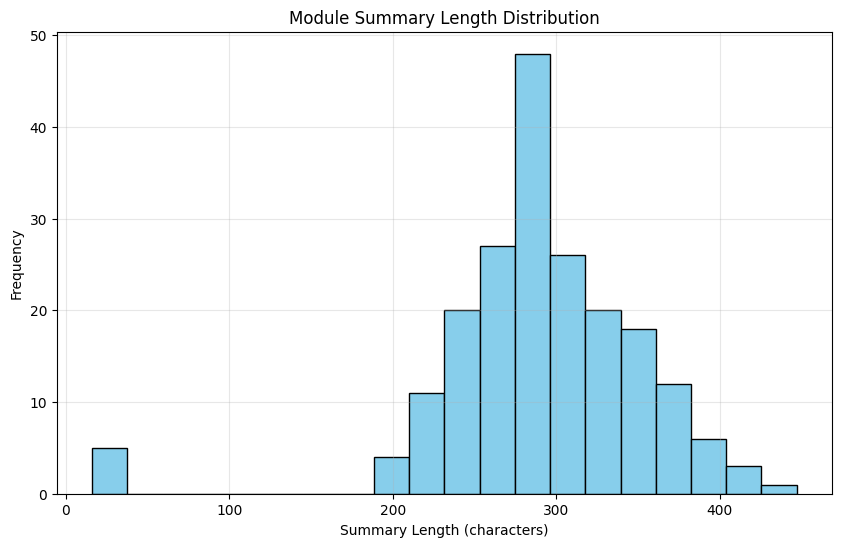

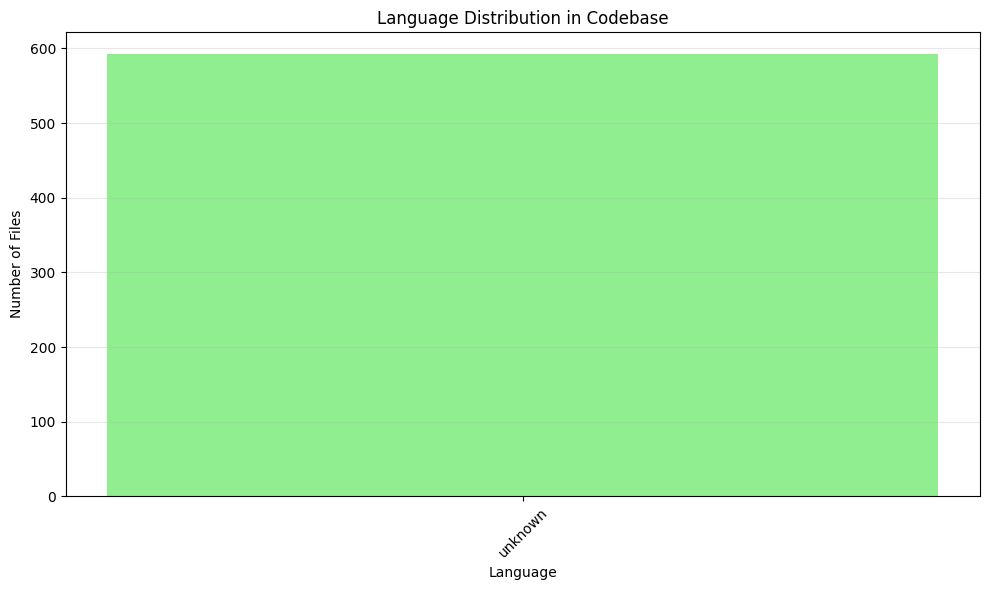

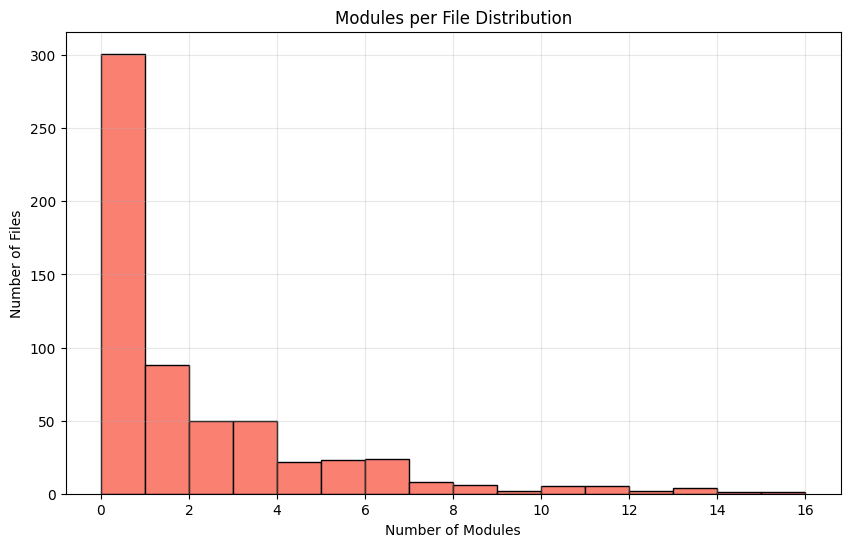


Step 5: Reviewing sample files

--- log_8.txt ---
# MODULE SUMMARIES:
# rtos_abstraction_layer: The rtos_abstraction_layer module provides an abstraction layer for Real-Time Operating System (RTOS) functionality, offering platform-independent interfaces for common RTOS services like memory allocation, thread management, mutexes, message queues, and timers used throughout the networking stack.

# FUNCTION SUMMARIES:
# _os_log_raw: Handles  os log raw processing format, ... returning void
# _os_log: Handles  os log processing level, func, component, format, ... returning void


/*
 * Copyright 2017-2019, 2021, 2023-2024 NXP
 *
 * SPDX-License-Identifier: BSD-3-Clause
 */

/**
 @file
 @brief RTOS logging services
 @details Linux logging services implementation
*/

#include "rtos_abstraction_layer.h"

#include "common/log.h"

void _os_log_raw(const char *format, ...)
{
	va_list ap;

	va_start(ap, format);

	rtos_vprintf(format, ap);

	va_end(ap);
}


void _os_log(const char *level, const 

Uploading files:   0%|          | 0/592 [00:00<?, ?it/s]

Successfully processed 592 out of 592 files
New files: 0, Updated files: 0, Unchanged files: 0
Successfully uploaded augmented codebase to S3
Data is available at s3://testingknowledgebase-nxp/tsn_data//

Process completed!


In [ ]:
# Cell 14: Actual Execution (uncomment to run)
main()